# Analysis of Leios simulations at tag `leios-2025w11`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
})

## Receipt of messages

### Read results

In [2]:
receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w11", collection="receipts")$find(), stringsAsFactors=TRUE)
receipts %>% summary

    elapsed        ib-body-avg-size-bytes ib-generation-probability
 Min.   :  0.000   Min.   : 32768         Min.   : 0.10            
 1st Qu.:  1.002   1st Qu.: 65536         1st Qu.:10.00            
 Median :  1.626   Median : 98304         Median :30.00            
 Mean   :  2.113   Mean   : 96928         Mean   :21.75            
 3rd Qu.:  2.372   3rd Qu.:131072         3rd Qu.:30.00            
 Max.   :140.268   Max.   :163840         Max.   :50.00            
 NA's   :94                                                        
        item          kind                  label         
 0-node-33:    9400   EB:  114700   default    :22175951  
 0-node-91:    9400   IB:20243163   with-cpu   : 1384917  
 23-0     :    9400   RB:  112997   without-cpu: 1522651  
 33-0     :    9400   VT: 4612659                         
 35-0     :    9400                                       
 (Other)  :24979046                                       
 NA's     :   57473                        

In [3]:
fwrite(receipts, "results/receipts.csv")

### Scenarios present in dataset

In [4]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
rust,100,default,11304471
rust,100,with-cpu,538823
rust,100,without-cpu,672538
haskell,100,default,10871480
haskell,100,with-cpu,846094
haskell,100,without-cpu,850113


### Delay due to CPU usage

In [5]:
receiptsCpu <-
receipts[
    `label` %in% c("with-cpu", "without-cpu") & 
    `network` == 100 & 
    `ib-body-avg-size-bytes` == 98304 &
    `leios-stage-length-slots` == 20 &
    `kind` == "IB"
]

#### Histogram of elapsed time from IB generation to receipt at a node

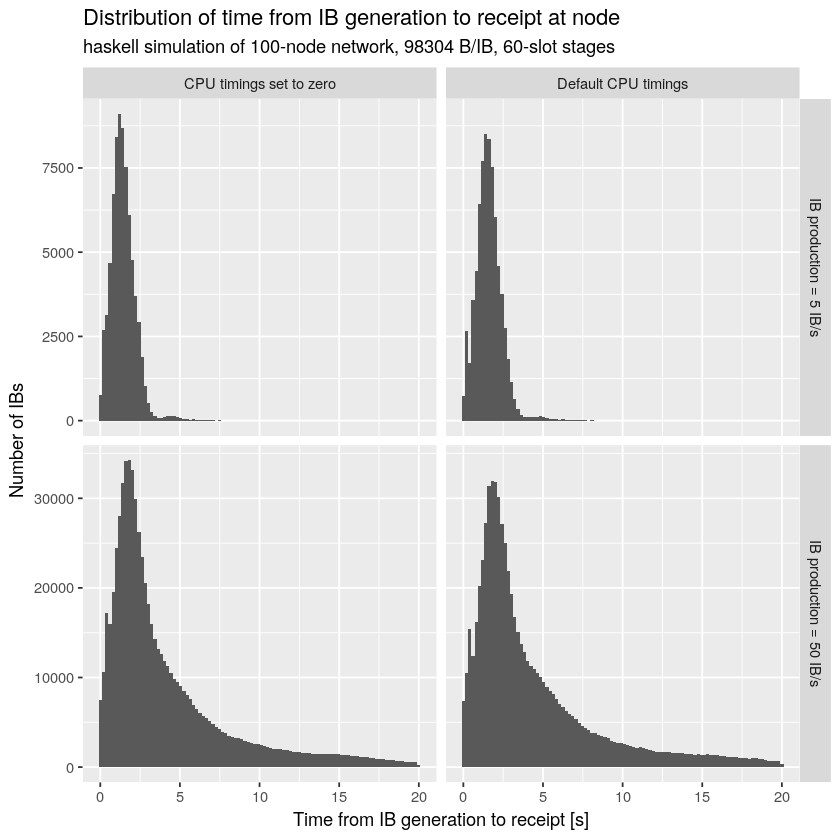

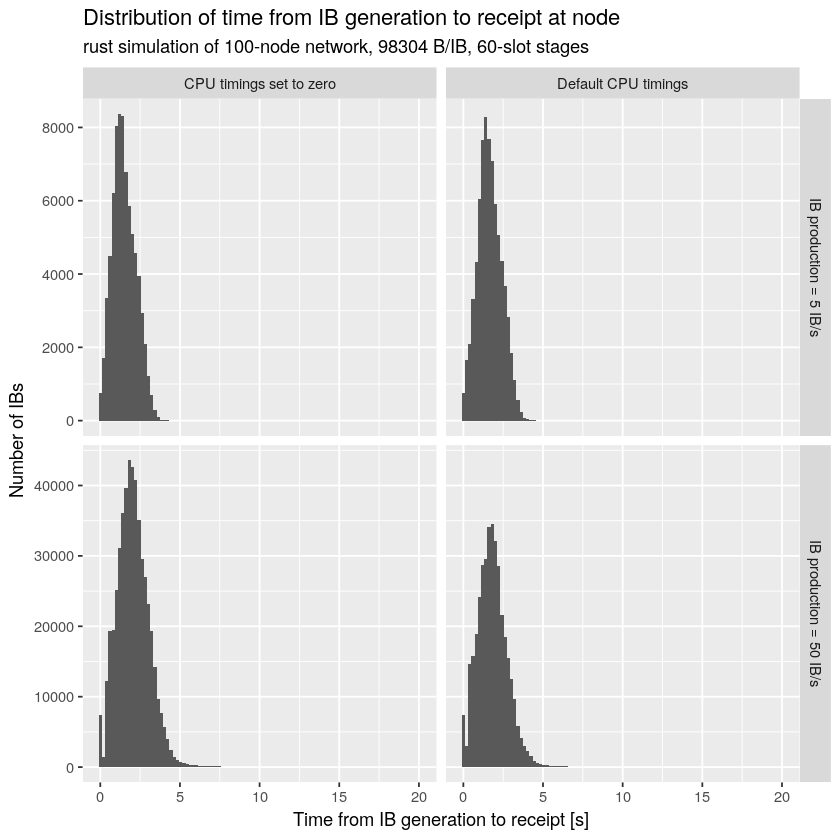

In [6]:
for (s in c("haskell", "rust")) {

g <- ggplot(receiptsCpu[`simulator` == s & `elapsed` <= 20, .(
        `label`=ifelse(`label` == "with-cpu", "Default CPU timings", "CPU timings set to zero"),
        `ibRate`=paste("IB production =", `ib-generation-probability`, "IB/s"),
        `elapsed`
    )], aes(x=`elapsed`)) +
    geom_histogram(bins=100) +
    facet_grid(`ibRate` ~ `label`, scales="free_y") +
    xlab("Time from IB generation to receipt [s]") +
    ylab("Number of IBs") +
    ggtitle(
        "Distribution of time from IB generation to receipt at node", 
        subtitle=paste(s, "simulation of 100-node network, 98304 B/IB, 60-slot stages")
    )
print(g)
    
}

### IB rate vs IB size vs stage length

In [7]:
receiptsDefault <-
receipts[
    `label` == "default" & 
    `network` == 100 &
    !is.na(`received`) &
    !(`simulator` == "rust" & `kind` == "RB")
]

#### Histogram of elapsed time for all items

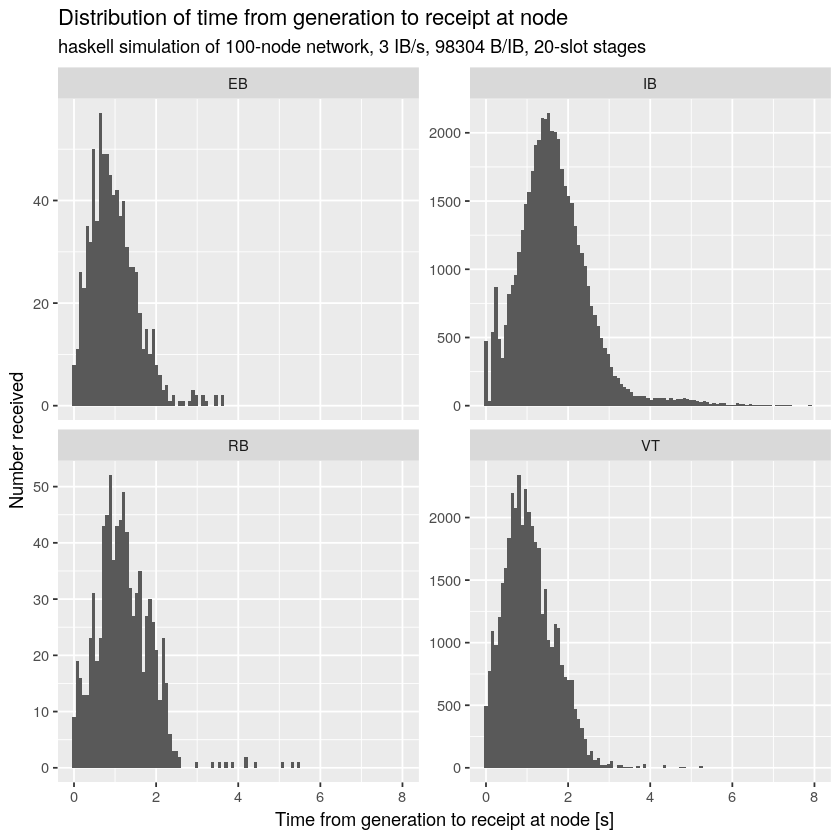

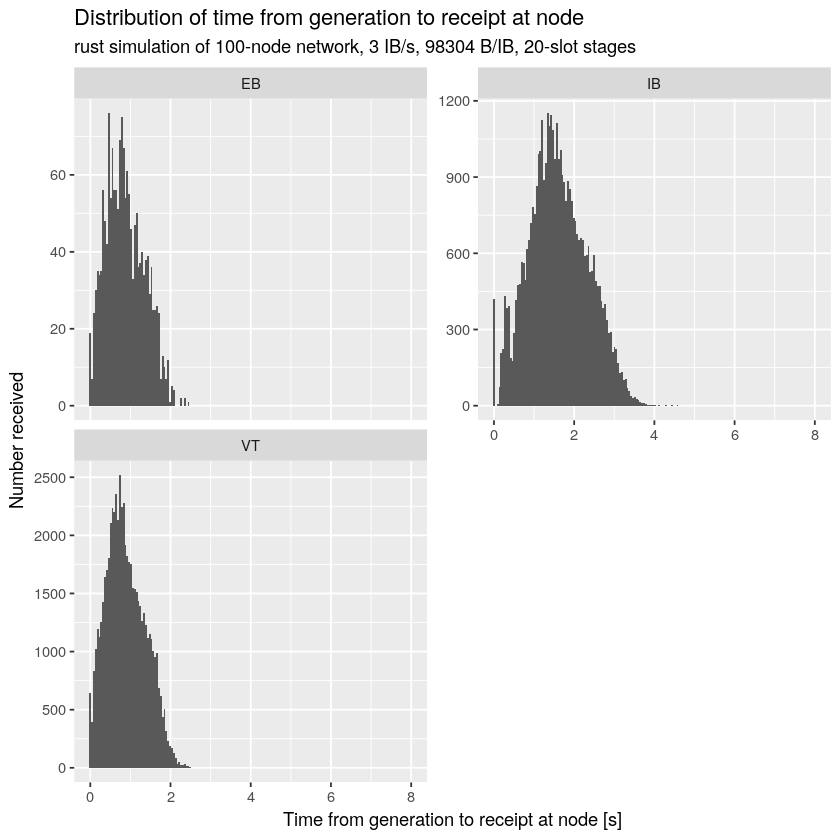

In [8]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    receiptsDefault[`simulator` == s & `ib-generation-probability` == 3 & `ib-body-avg-size-bytes` == 98304 & `leios-stage-length-slots` == 20],
    aes(x=`elapsed`)
) +
    geom_histogram(bins=100) +
    facet_wrap(`kind` ~ ., scales="free_y", nrow=2) +
    coord_cartesian(xlim=c(0, 8)) +
    xlab("Time from generation to receipt at node [s]") +
    ylab("Number received") +
    ggtitle(
        "Distribution of time from generation to receipt at node", 
        subtitle=paste(s, "simulation of 100-node network, 3 IB/s, 98304 B/IB, 20-slot stages")
    )
print(g)
    
}

#### Compare the distributions of elapsed times

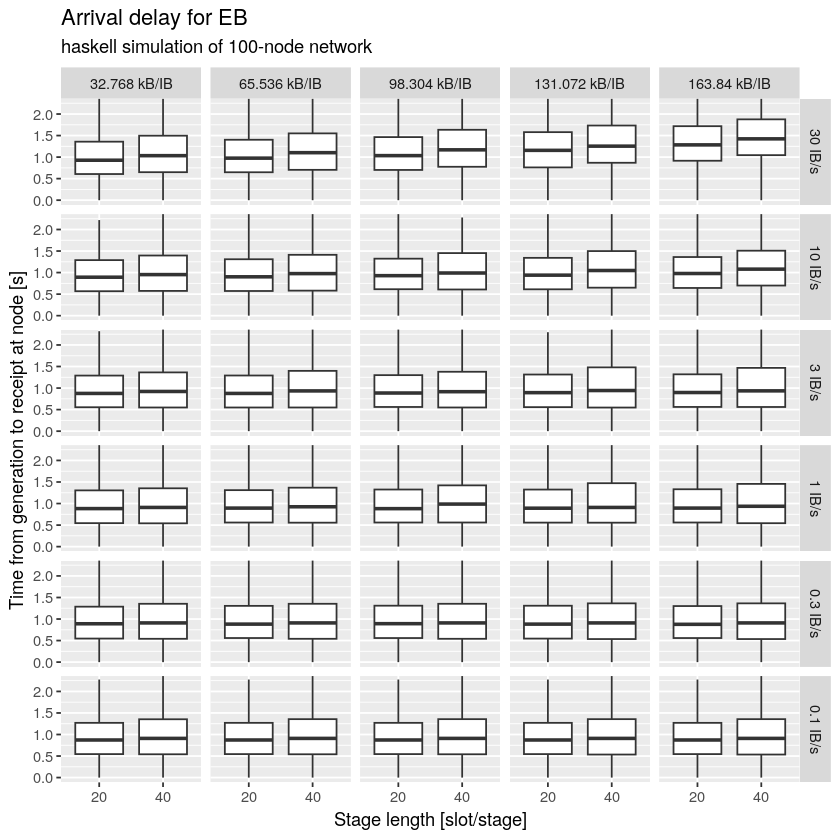

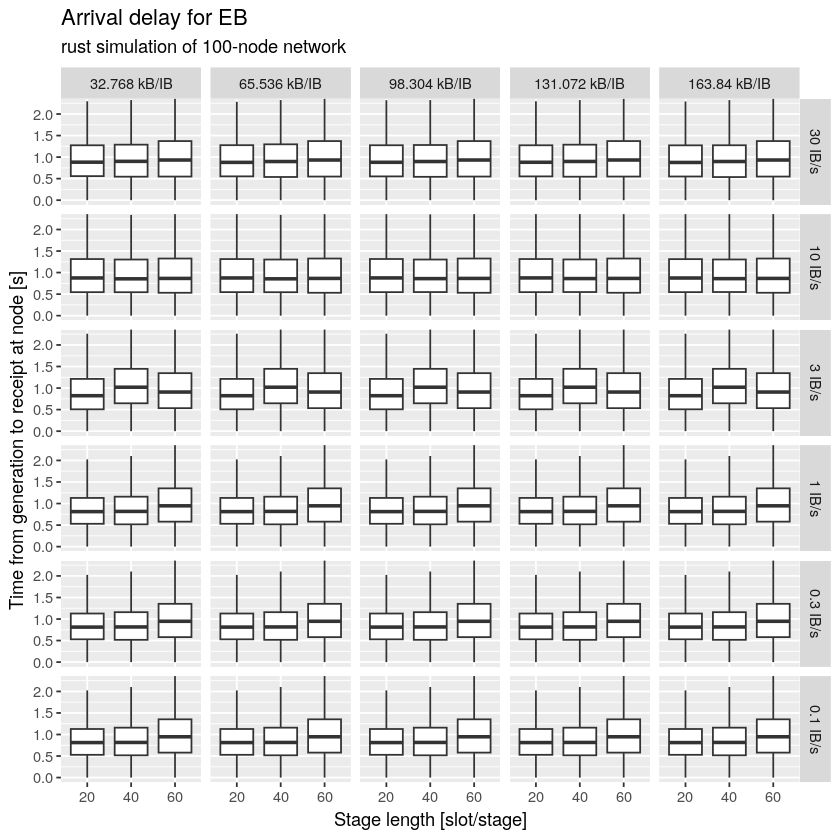

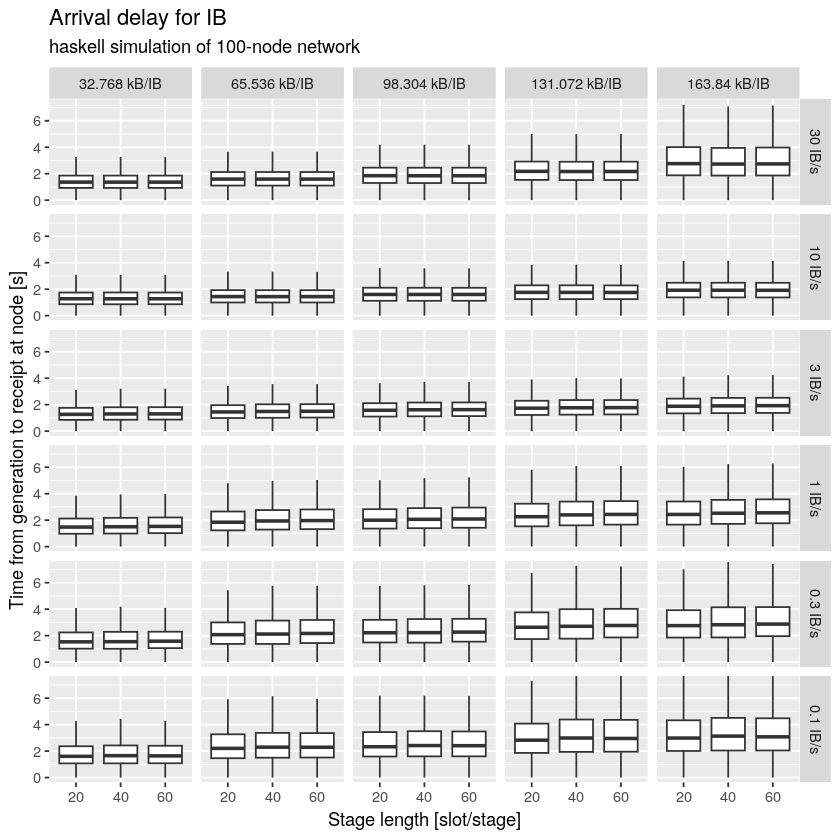

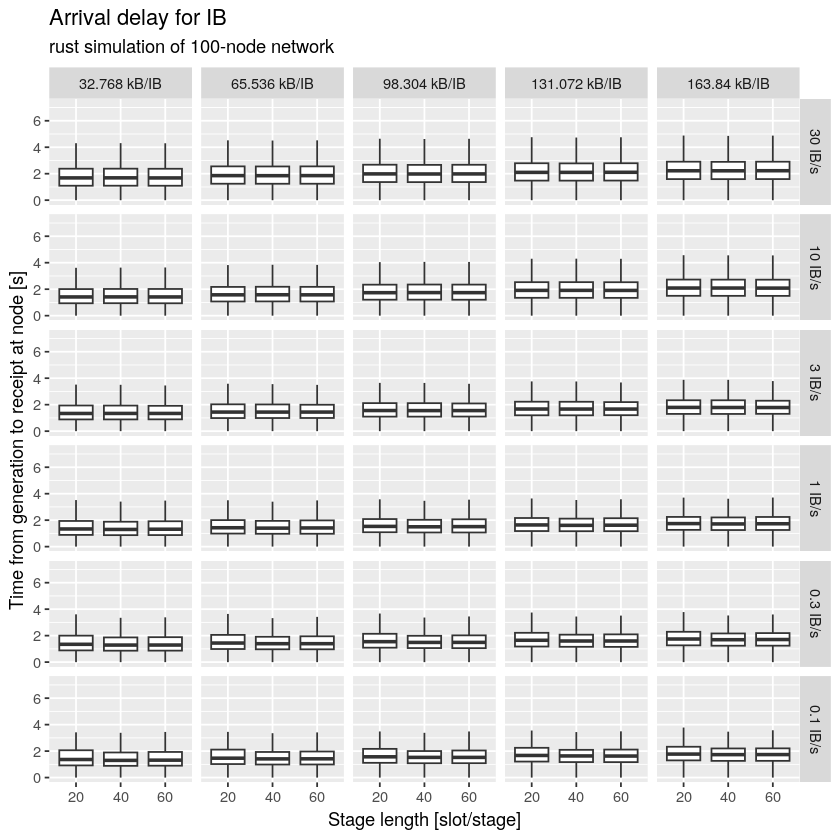

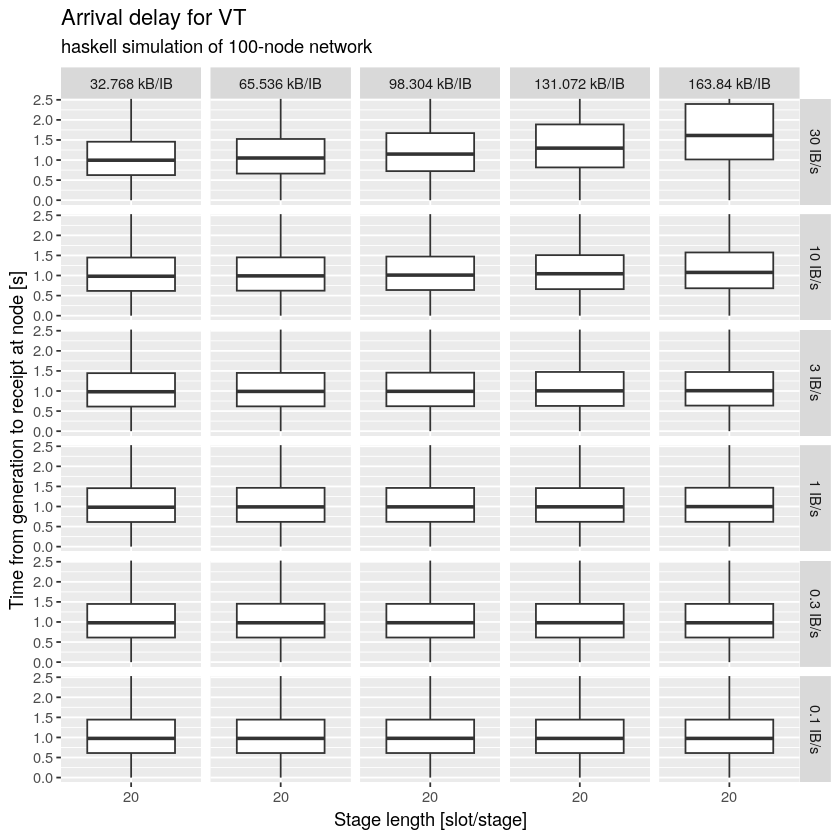

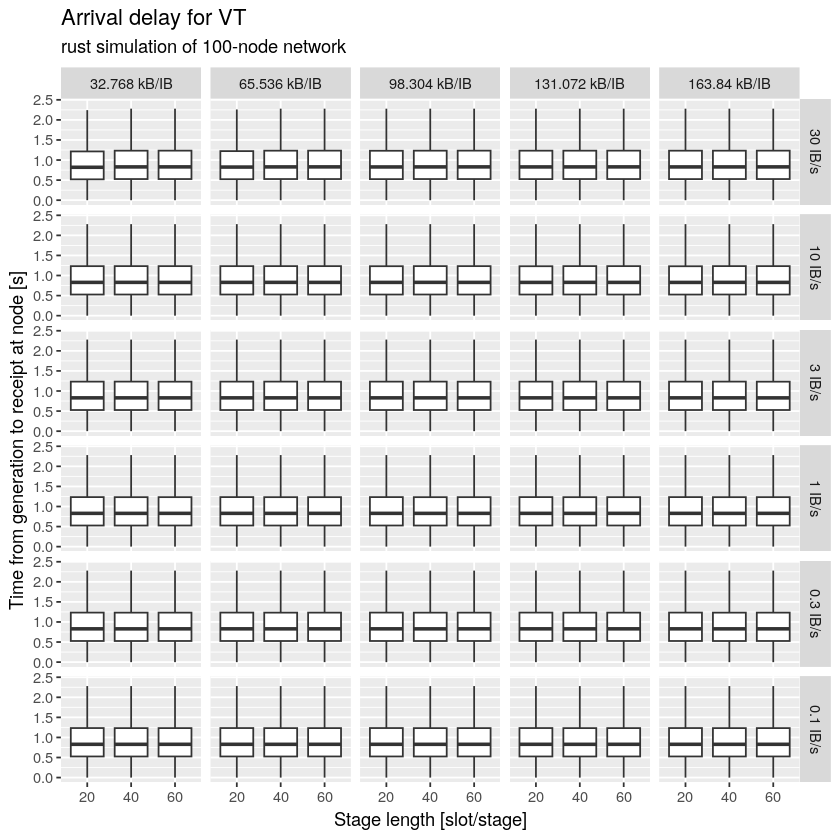

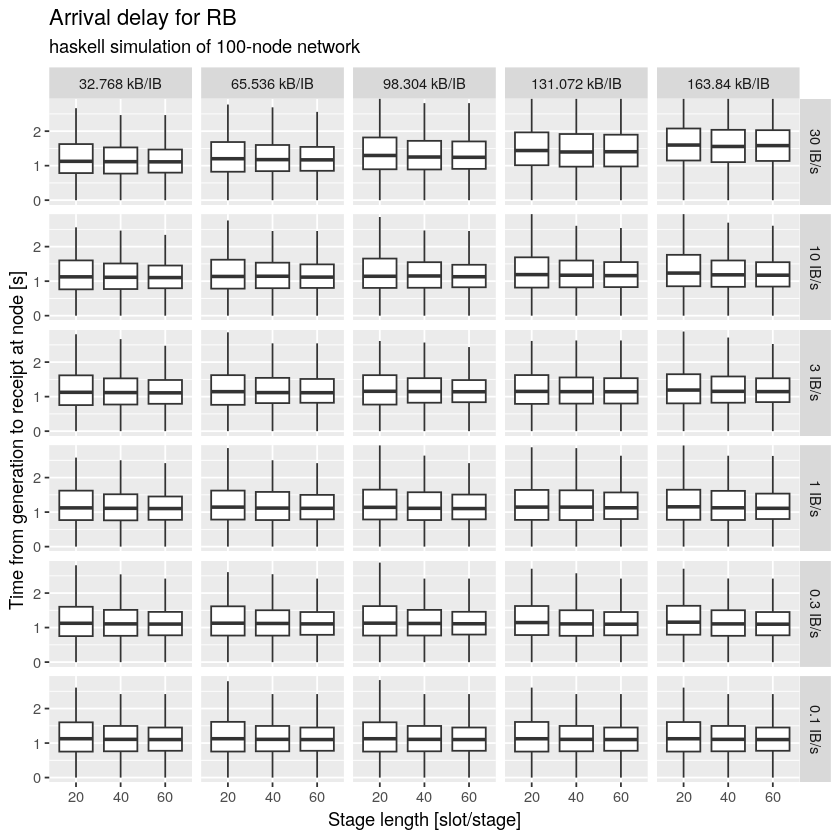

In [9]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in c("haskell", "rust")) {
    if (k == "RB" && s == "rust")
        next
    g <- ggplot(
        receiptsDefault[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `stageLength`=factor(`leios-stage-length-slots`),
                `elapsed`
            )
        ],
        aes(x=`stageLength`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`ibRate` ~ `ibSize`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("Stage length [slot/stage]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s, "simulation of 100-node network"))
    print(g)
}
}

#### Trends in elapsed times

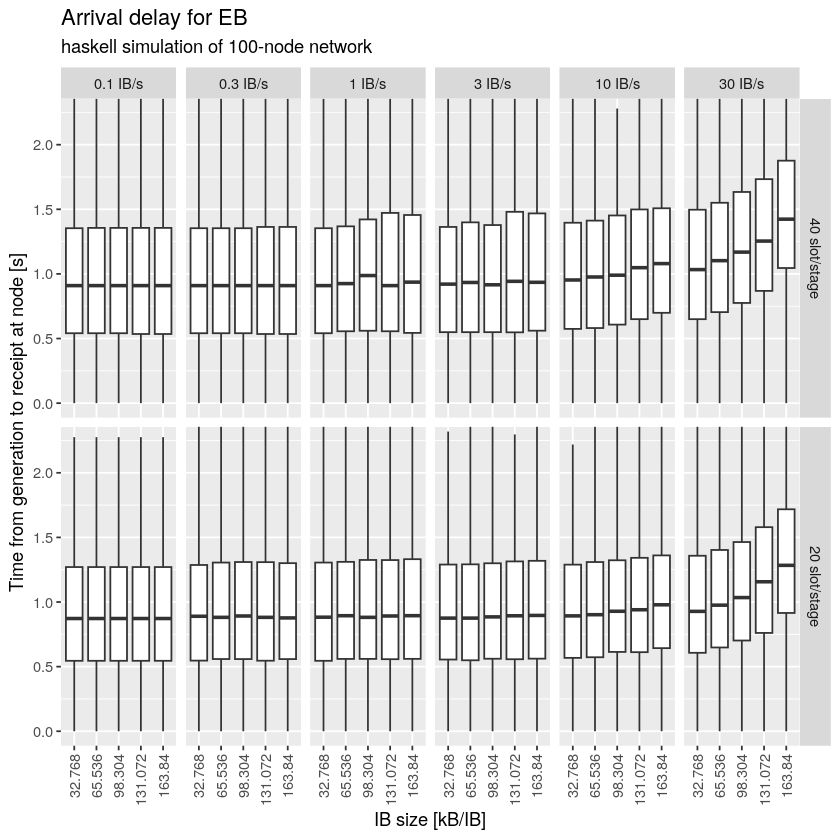

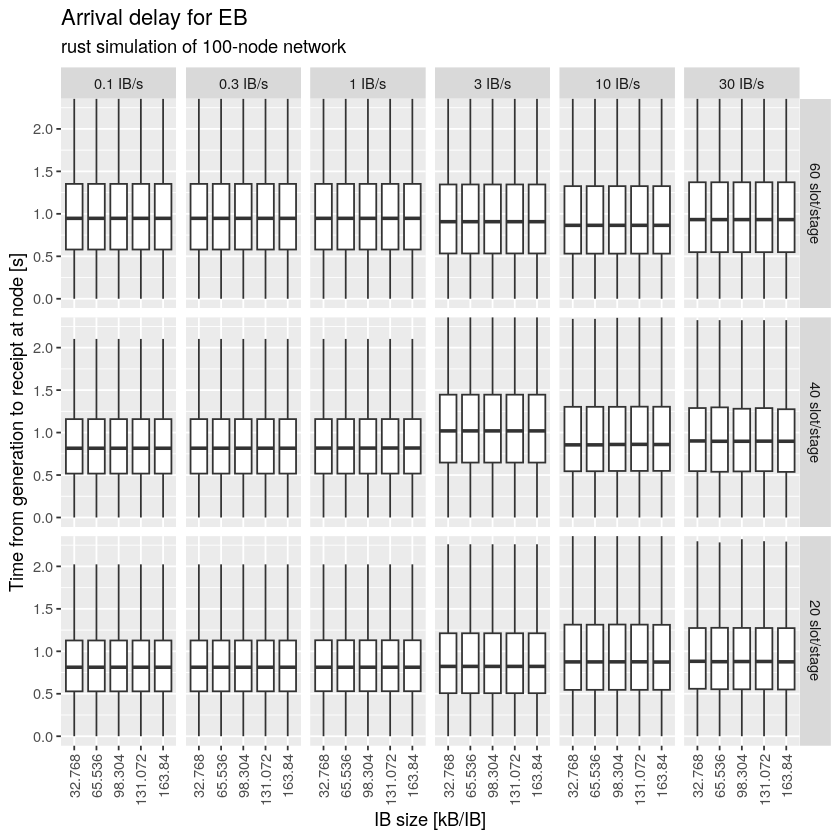

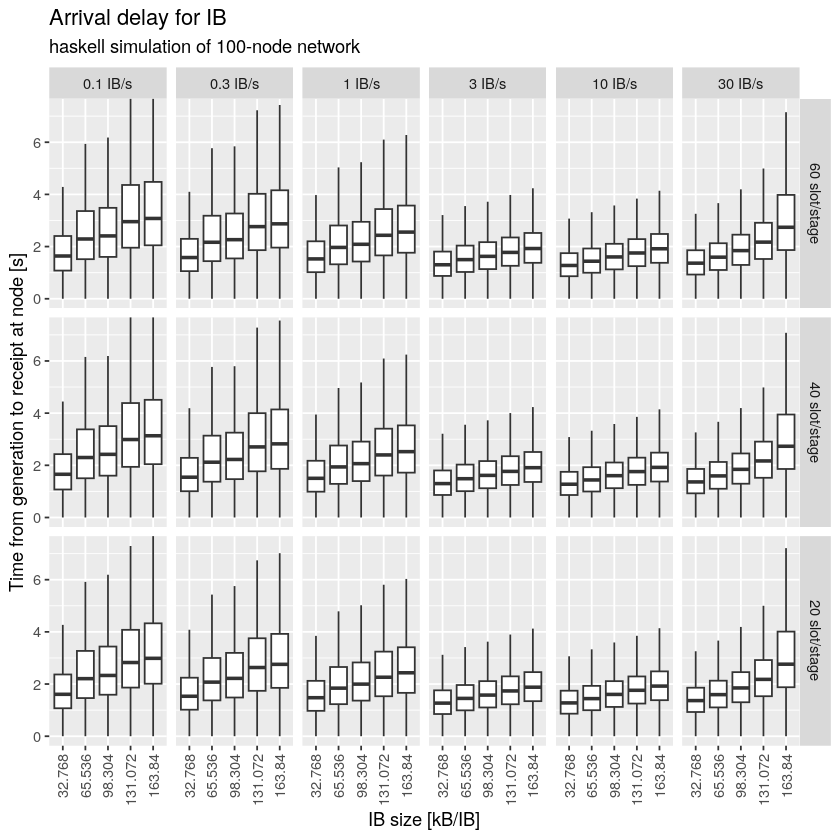

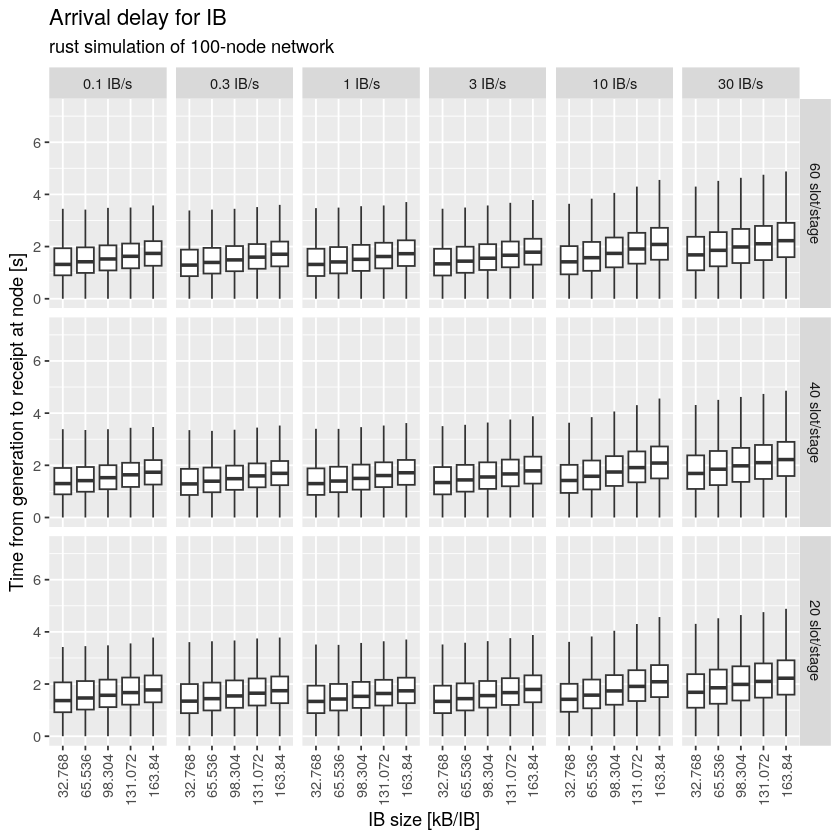

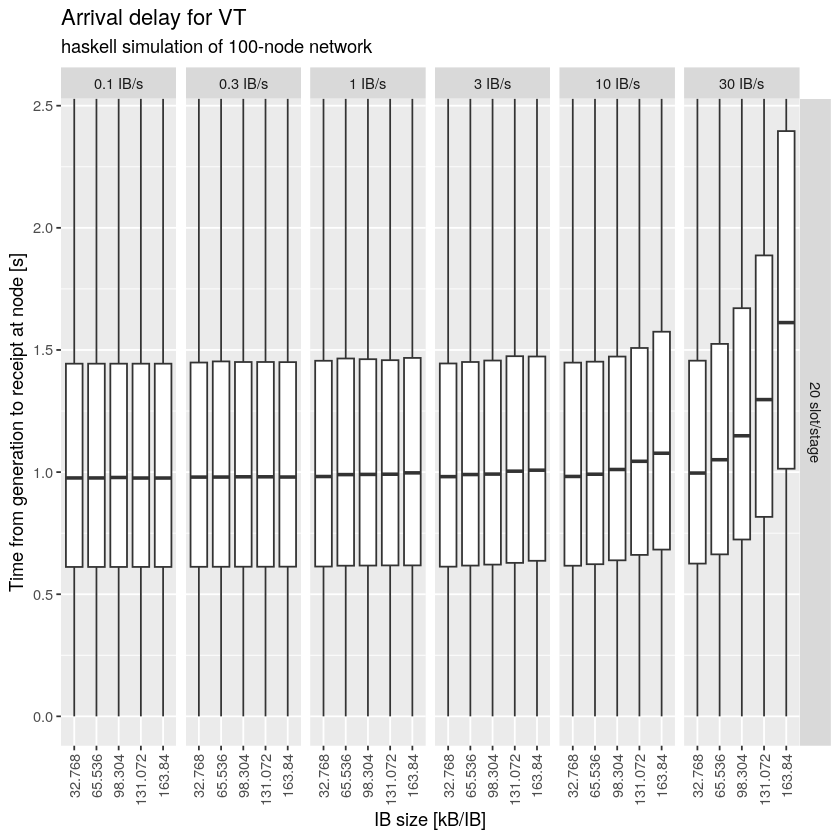

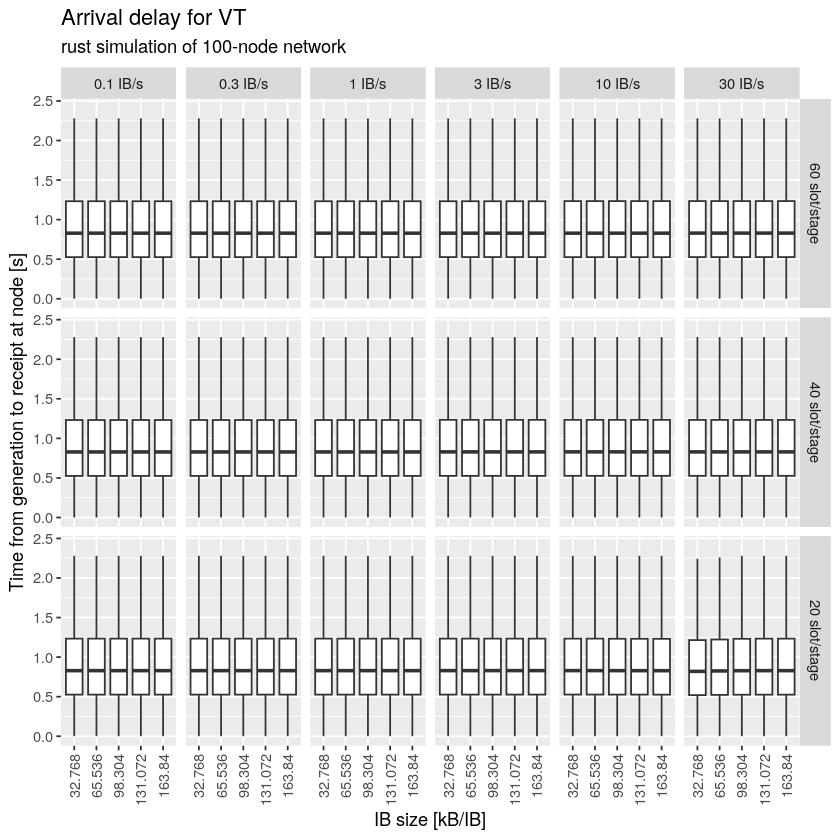

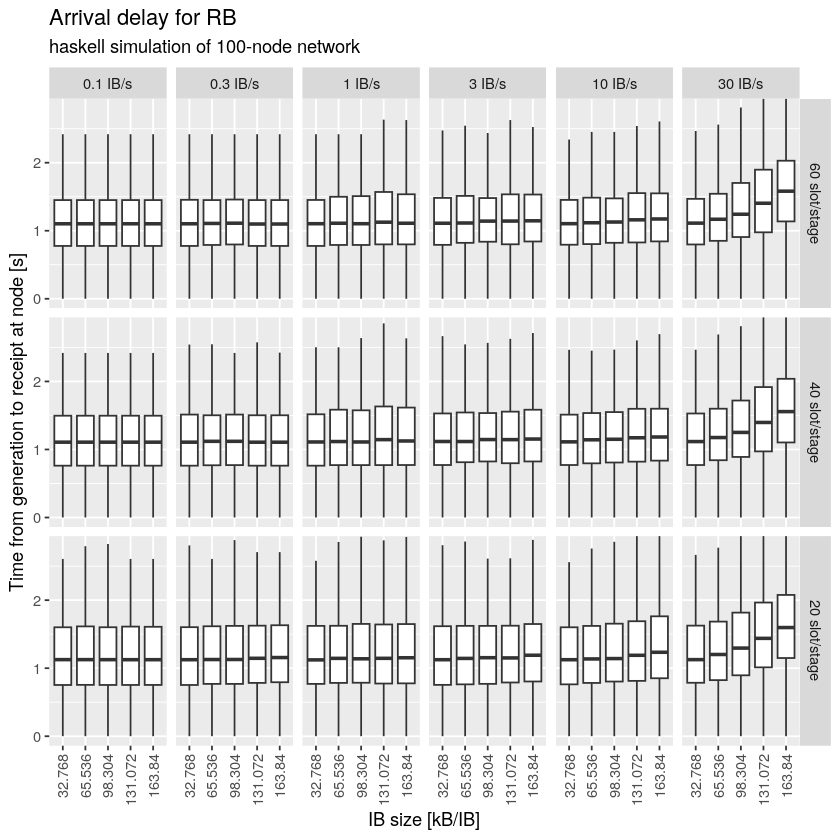

In [10]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in c("haskell", "rust")) {
    if (k == "RB" && s == "rust")
        next
    g <- ggplot(
        receiptsDefault[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`))], "IB/s")),
                `ibSize`=factor(`ib-body-avg-size-bytes`/1000),
                `stageLength`=factor(paste(`leios-stage-length-slots`, "slot/stage"), levels=paste(receiptsDefault[, sort(unique(`leios-stage-length-slots`),decreasing=TRUE)], "slot/stage")),
                `elapsed`
            )
        ],
        aes(x=`ibSize`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`stageLength` ~ `ibRate`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("IB size [kB/IB]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s, "simulation of 100-node network")) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

    print(g)
}
}

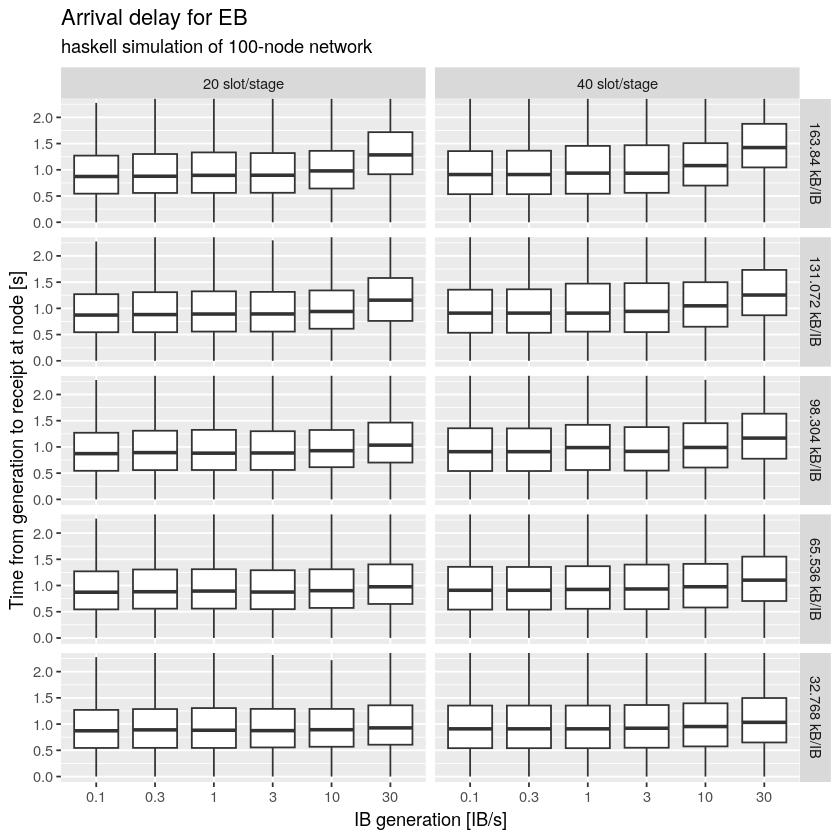

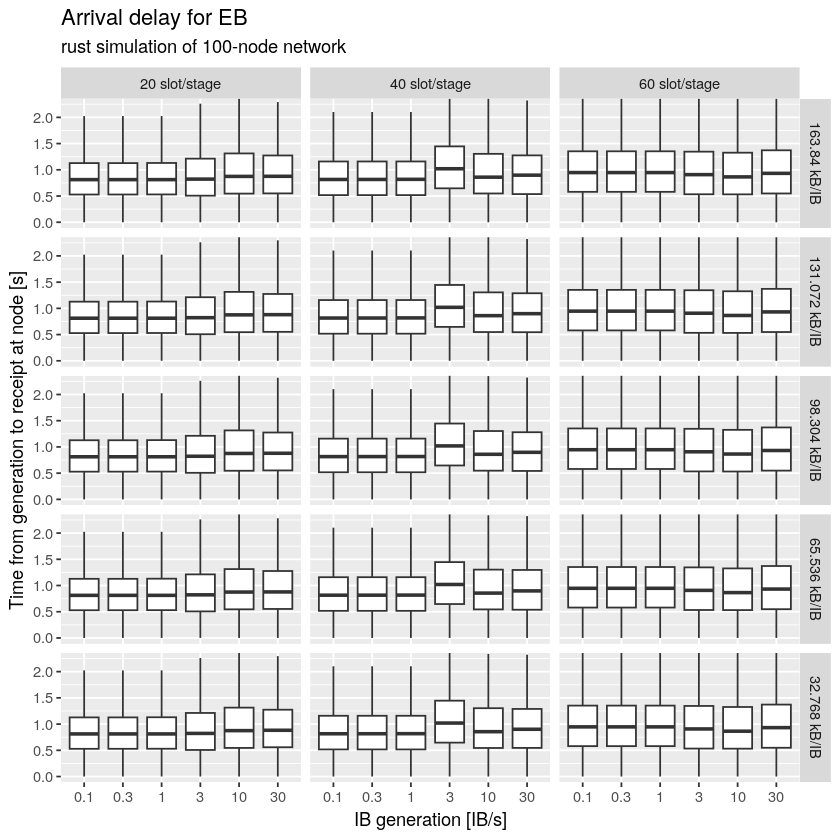

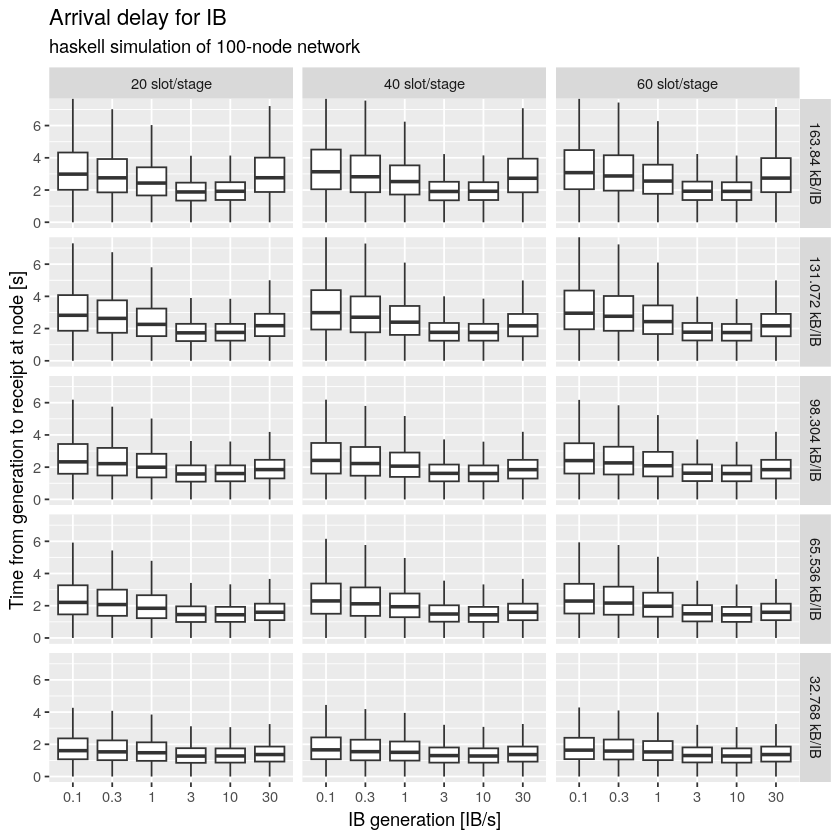

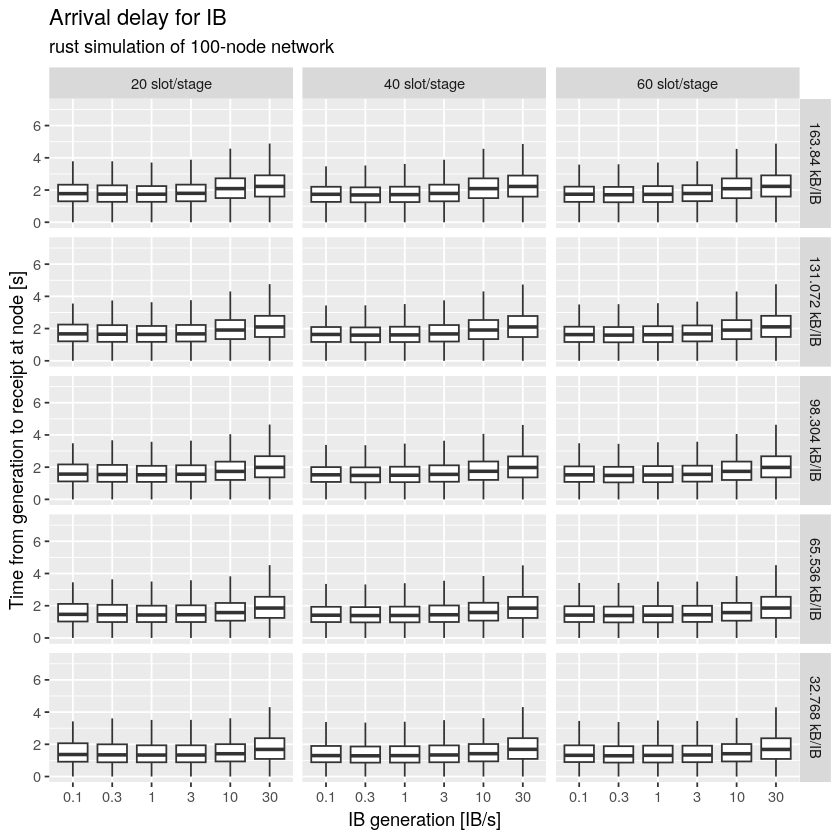

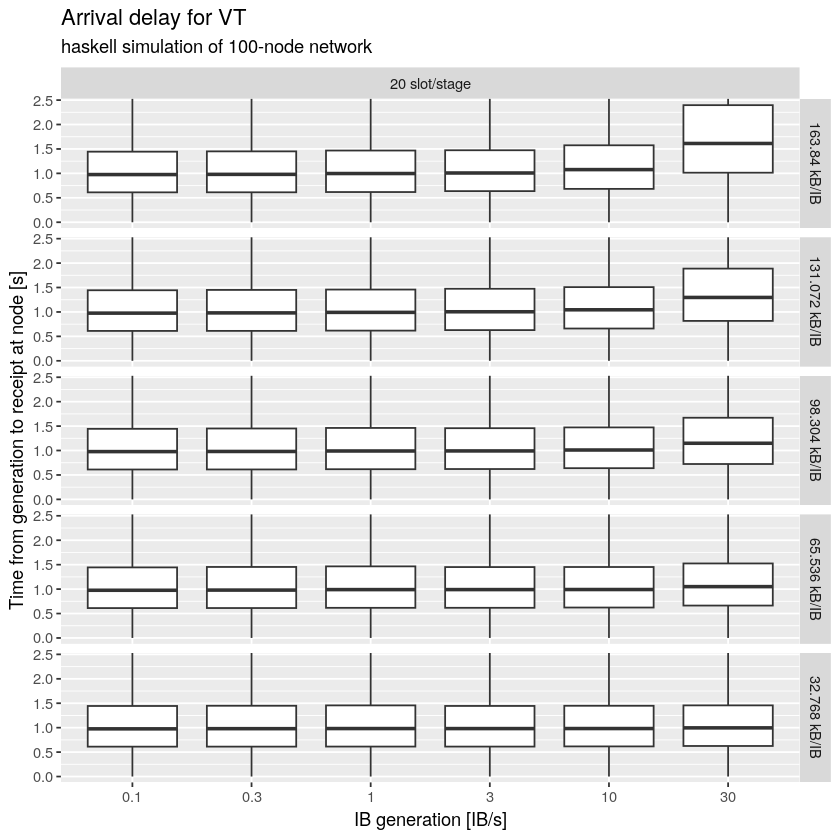

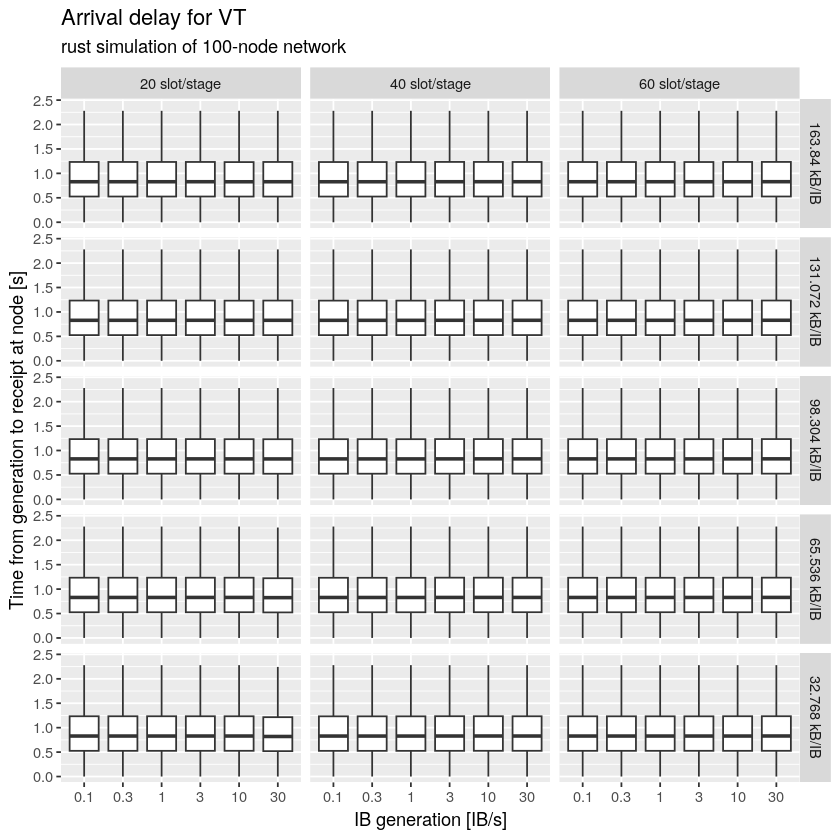

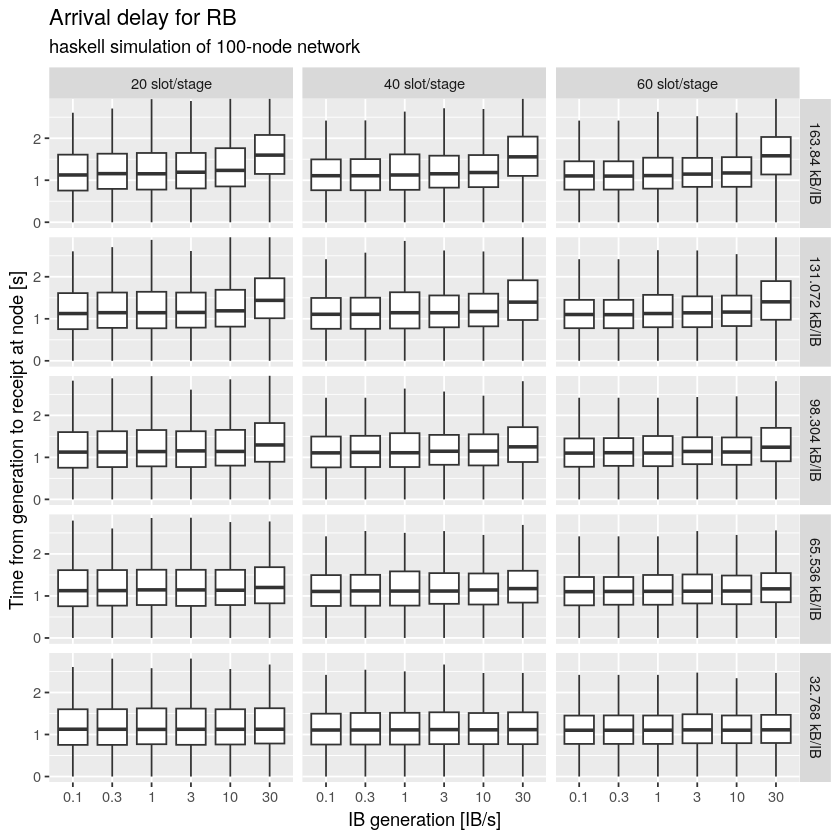

In [11]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in c("haskell", "rust")) {
    if (k == "RB" && s == "rust")
        next
    g <- ggplot(
        receiptsDefault[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(`ib-generation-probability`),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`),decreasing=TRUE)]/1000, "kB/IB")),
                `stageLength`=factor(paste(`leios-stage-length-slots`, "slot/stage"), levels=paste(receiptsDefault[, sort(unique(`leios-stage-length-slots`))], "slot/stage")),
                `elapsed`
            )
        ],
        aes(x=`ibRate`, y=`elapsed`)
    ) +
        geom_boxplot(outlier.shape=NA) +
        facet_grid(`ibSize` ~ `stageLength`) +
        coord_cartesian(ylim=c(0, receiptsDefault[`kind` == k, quantile(`elapsed`, probs=0.99)])) +
        xlab("IB generation [IB/s]") +
        ylab("Time from generation to receipt at node [s]") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s, "simulation of 100-node network"))

    print(g)
}
}

### Fraction of items arriving

In [12]:
arrival <- receiptsDefault[,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `leios-stage-length-slots`, `kind`, `sent`)
]

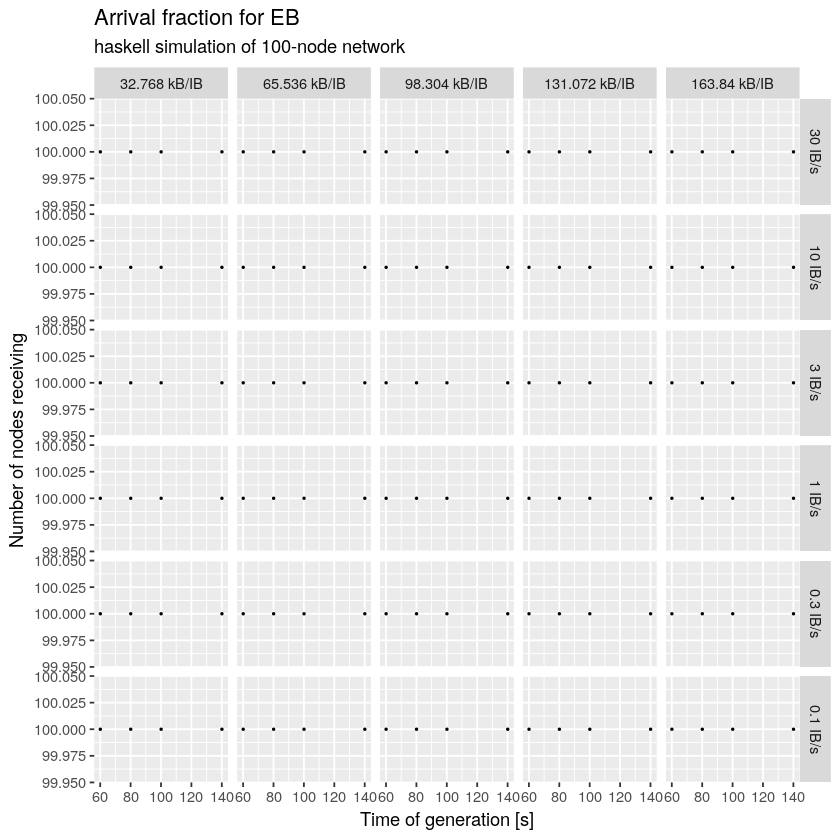

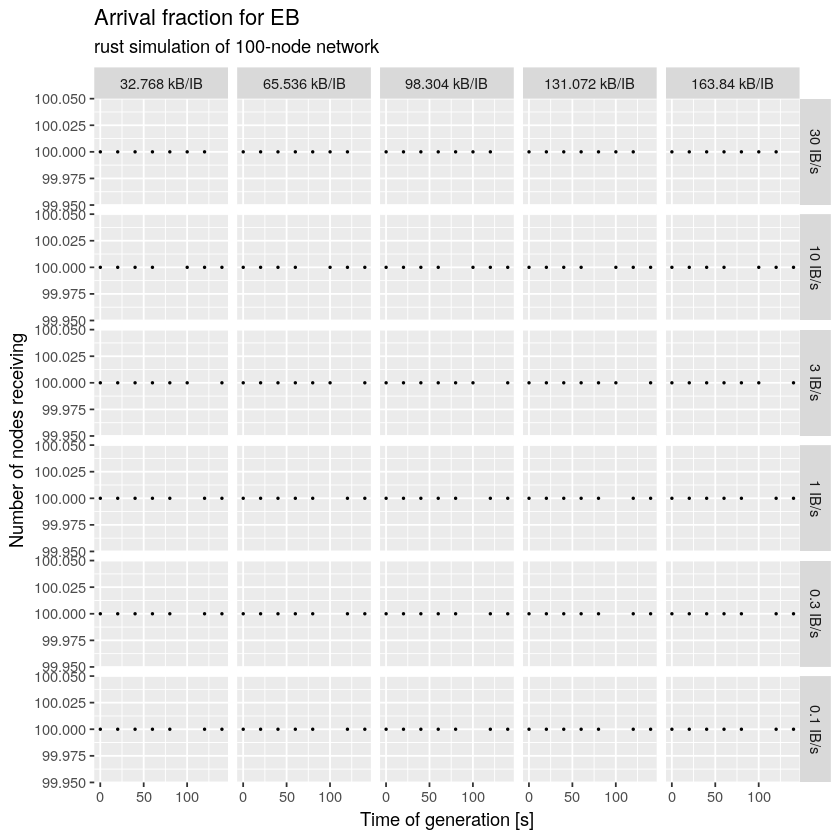

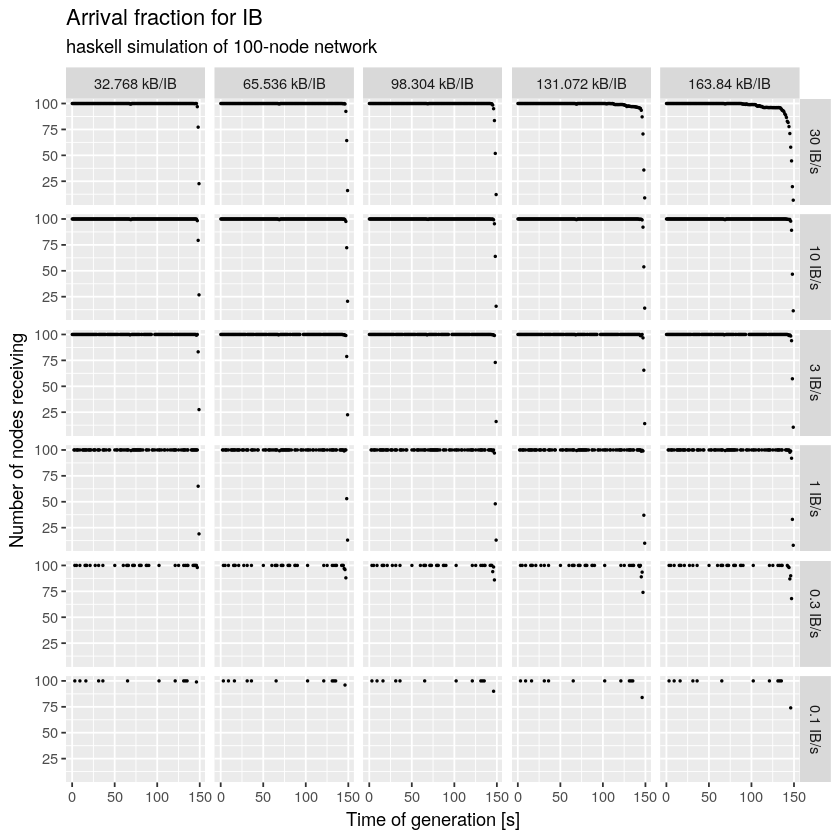

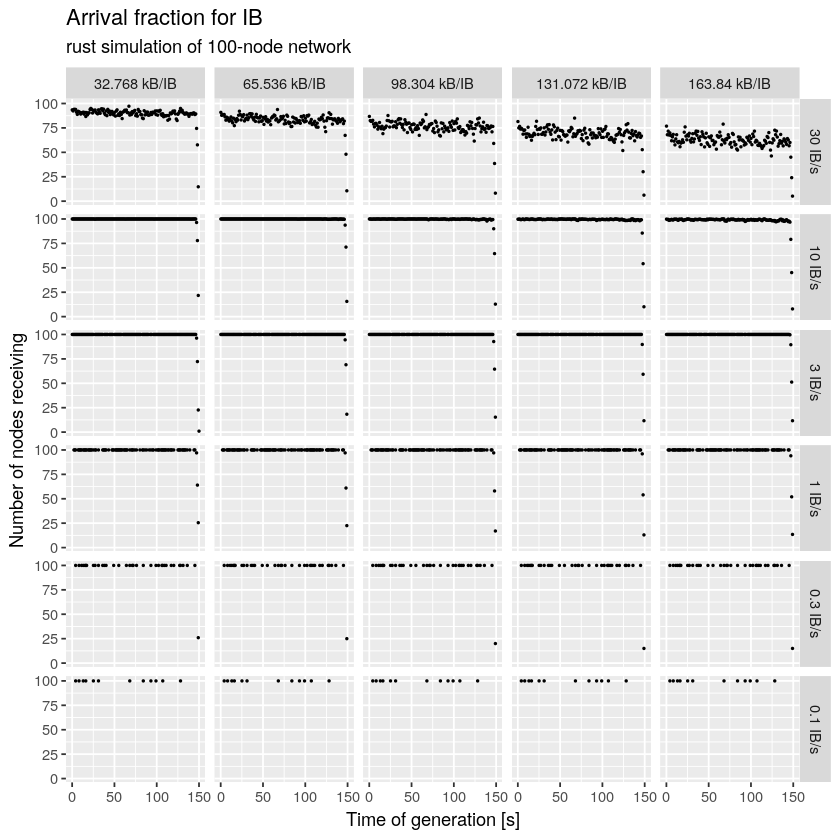

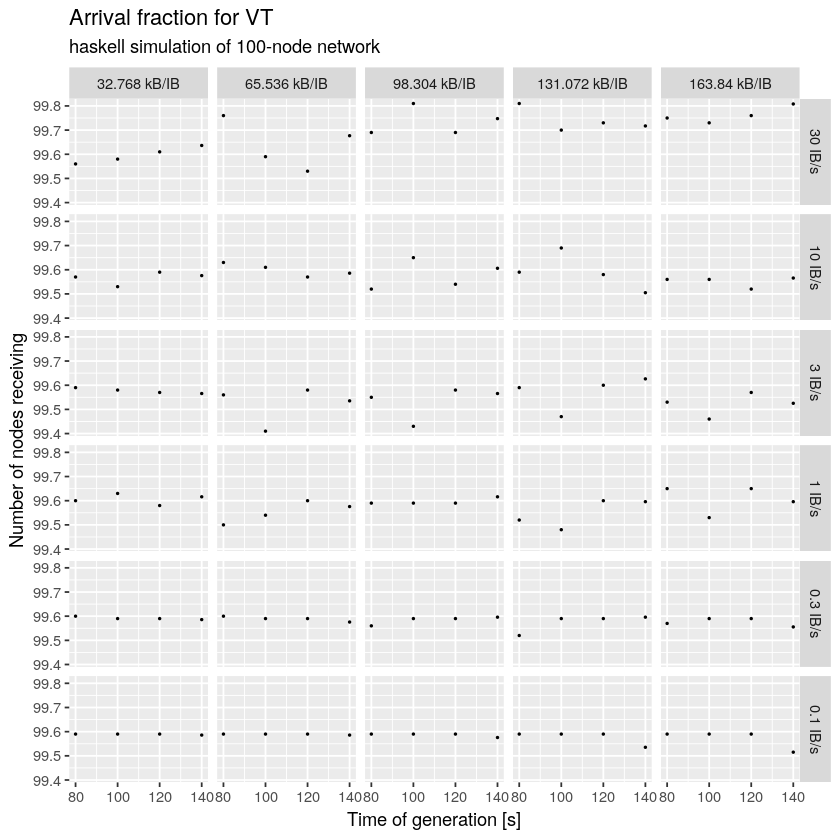

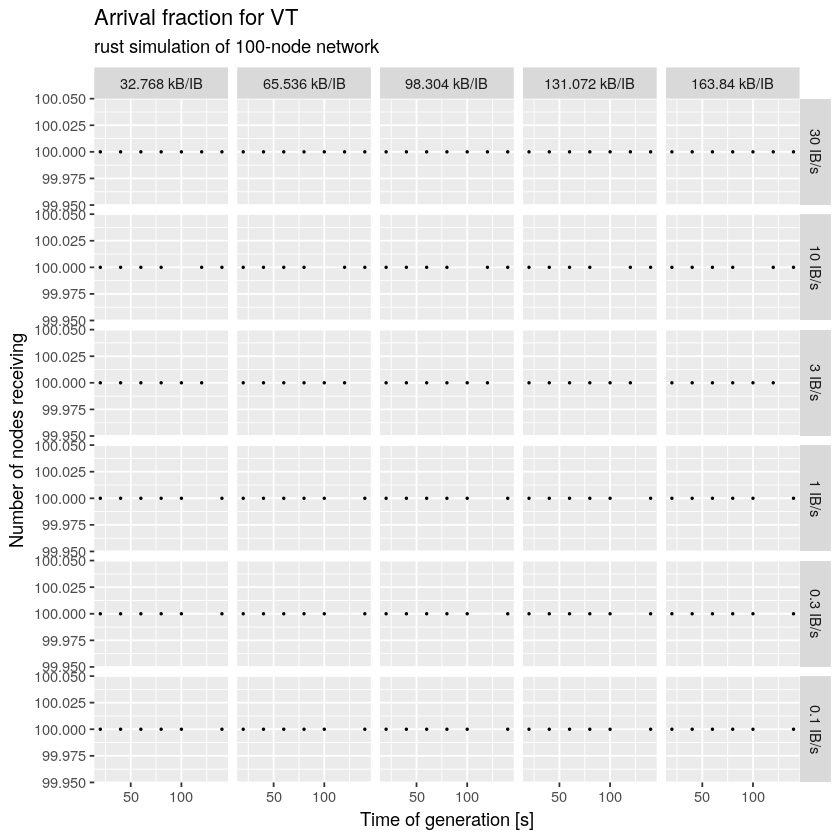

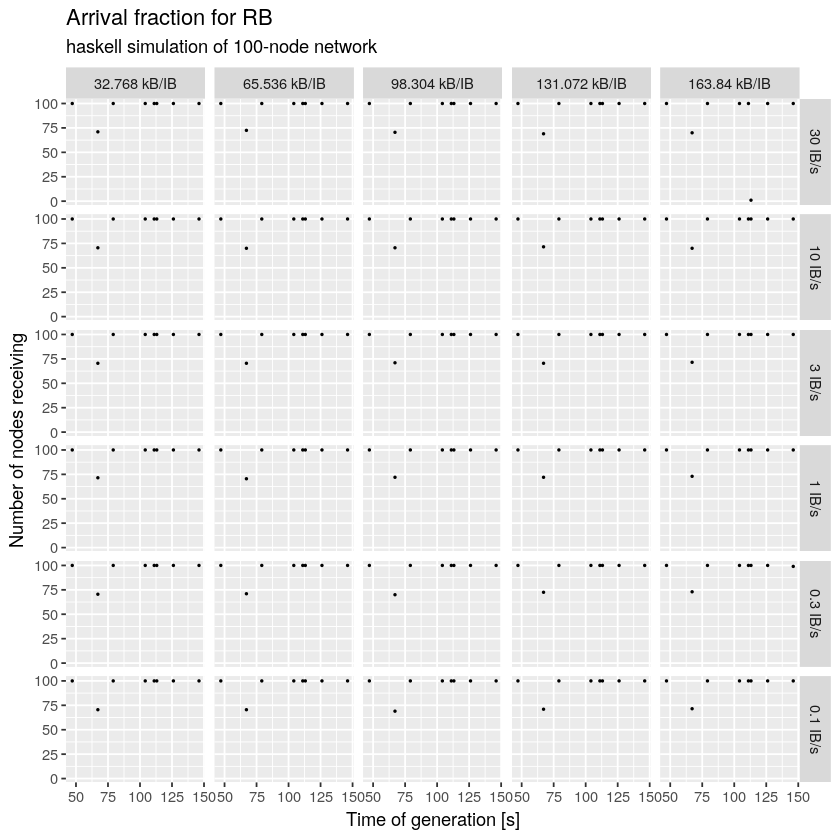

In [13]:
for (k in receiptsDefault[,unique(`kind`)]) {
for (s in c("haskell", "rust")) {
    if (k == "RB" && s == "rust")
        next
    g <- ggplot(
        arrival[
            `simulator` == s & `kind` == k & `leios-stage-length-slots` == 20,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receiptsDefault[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receiptsDefault[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.3) +
        facet_grid(`ibRate`  ~ `ibSize`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle=paste(s, "simulation of 100-node network"))
    print(g)
}
}

## CPU usage

### Read results

In [14]:
cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w11", collection="cpus")$find(), stringsAsFactors=TRUE)
cpus %>% summary

    duration        ib-body-avg-size-bytes ib-generation-probability
 Min.   :0.000164   Min.   : 32768         Min.   : 0.10            
 1st Qu.:0.032000   1st Qu.: 65536         1st Qu.: 1.00            
 Median :0.130000   Median : 98304         Median : 3.00            
 Mean   :0.530276   Mean   : 98543         Mean   :10.51            
 3rd Qu.:0.540288   3rd Qu.:131072         3rd Qu.:10.00            
 Max.   :5.936400   Max.   :163840         Max.   :30.00            
                                                                    
     label         leios-stage-length-slots network            node        
 default:3510237   Min.   :20.00            100:3510237   node-2 :  36045  
                   1st Qu.:20.00                          node-84:  35999  
                   Median :40.00                          node-74:  35995  
                   Mean   :39.24                          node-76:  35969  
                   3rd Qu.:60.00                          node-16:  

In [15]:
fwrite(cpus, "results/cpus.csv")

In [16]:
cpusNode <-
cpus[
    `network` == "100",
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

### Peak CPU usage

#### Histogram

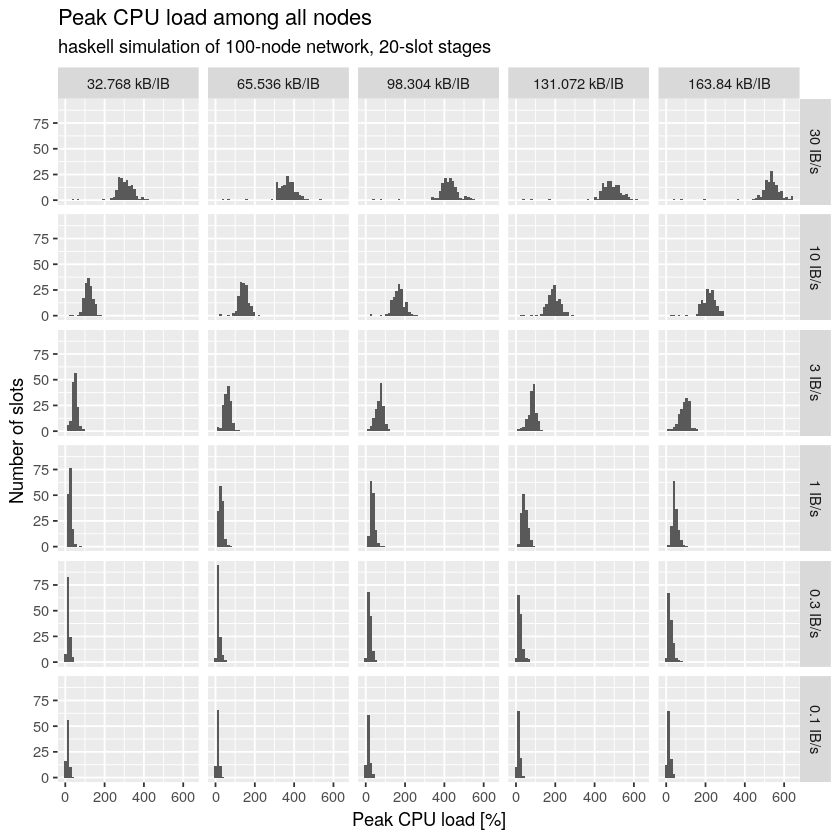

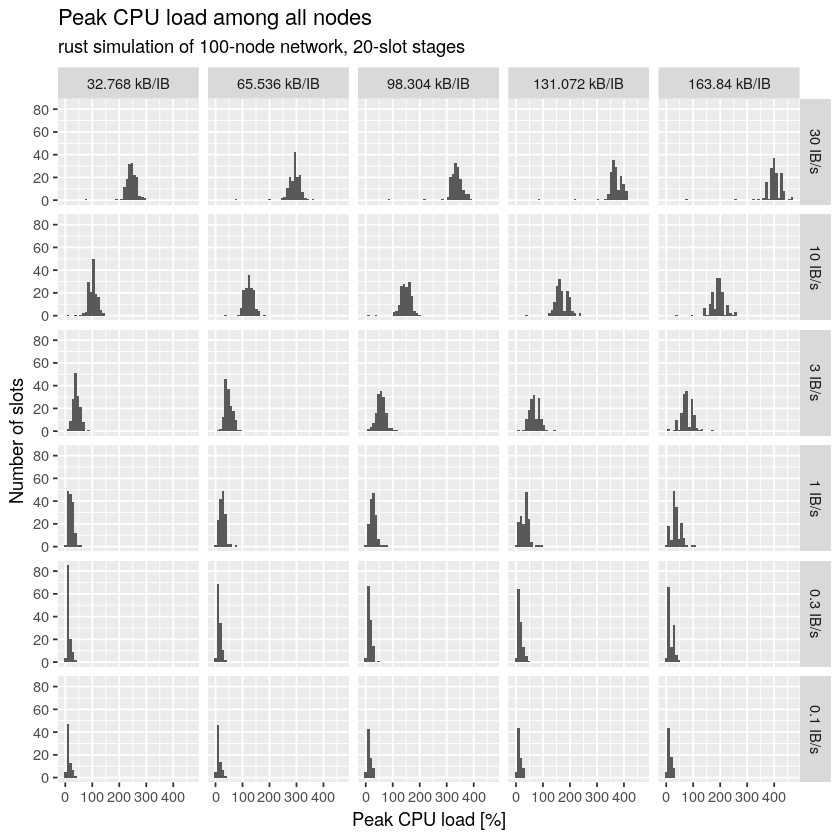

In [17]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(bins=50) +
#   geom_vline(xintercept=100, color="blue") +
    facet_grid(`ibRate` ~ `ibSize`) +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

#### Time series

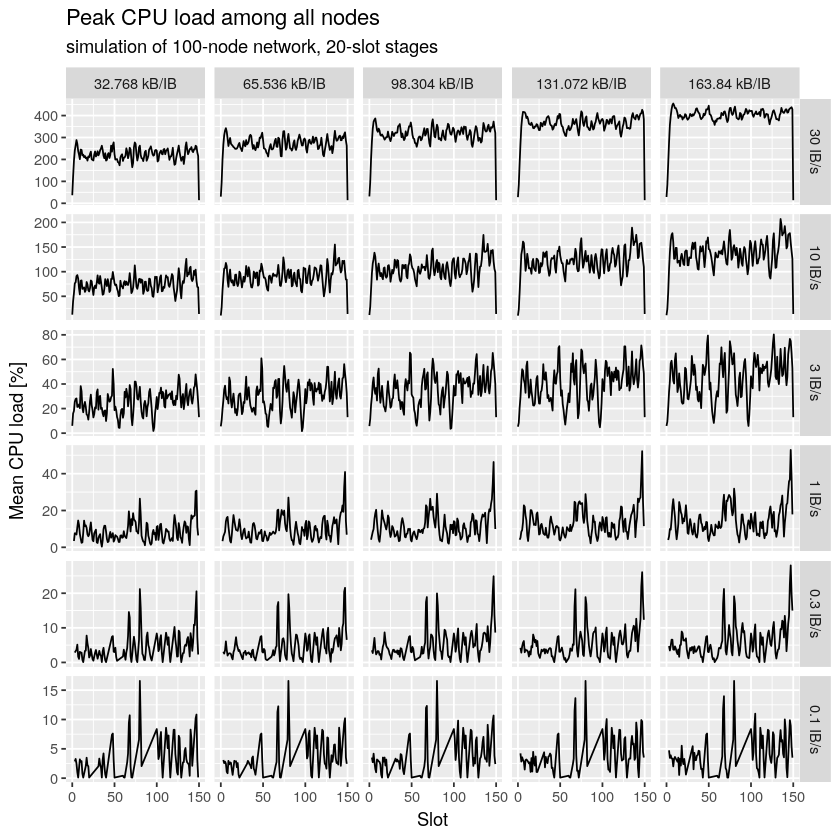

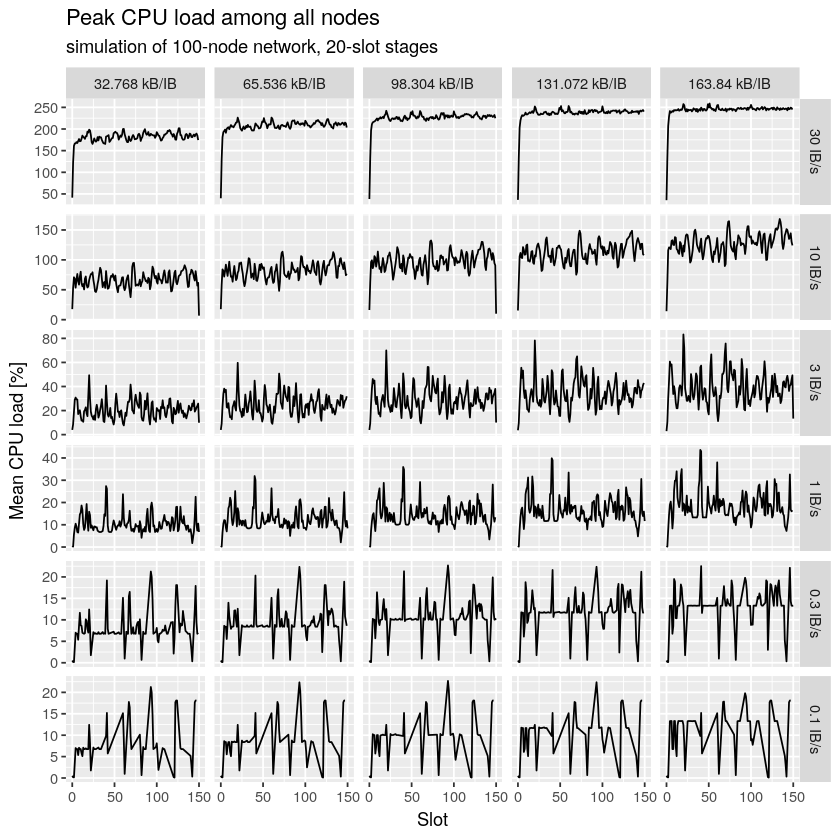

In [18]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste("simulation of 100-node network, 20-slot stages"))
print(g)

}

### Mean CPU usage

#### Histogram

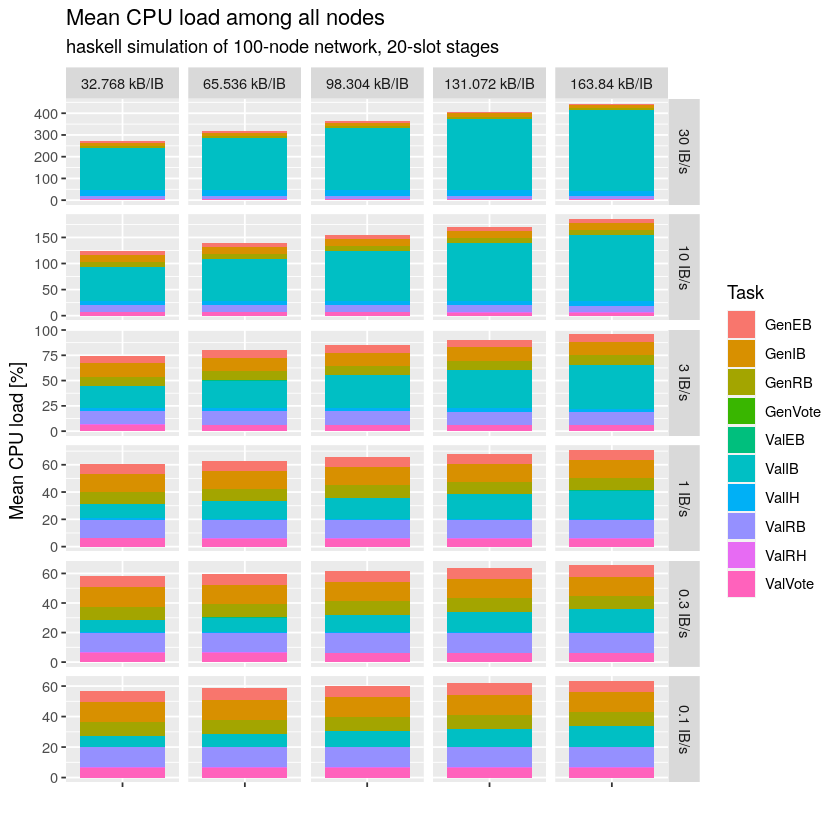

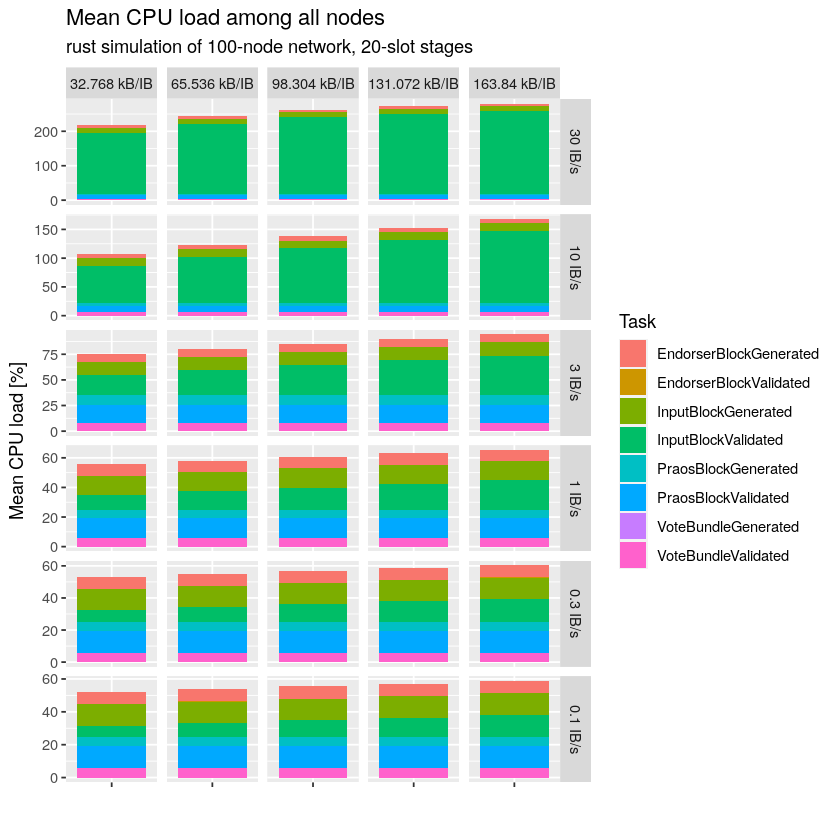

In [19]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=`task`
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

#### Time series

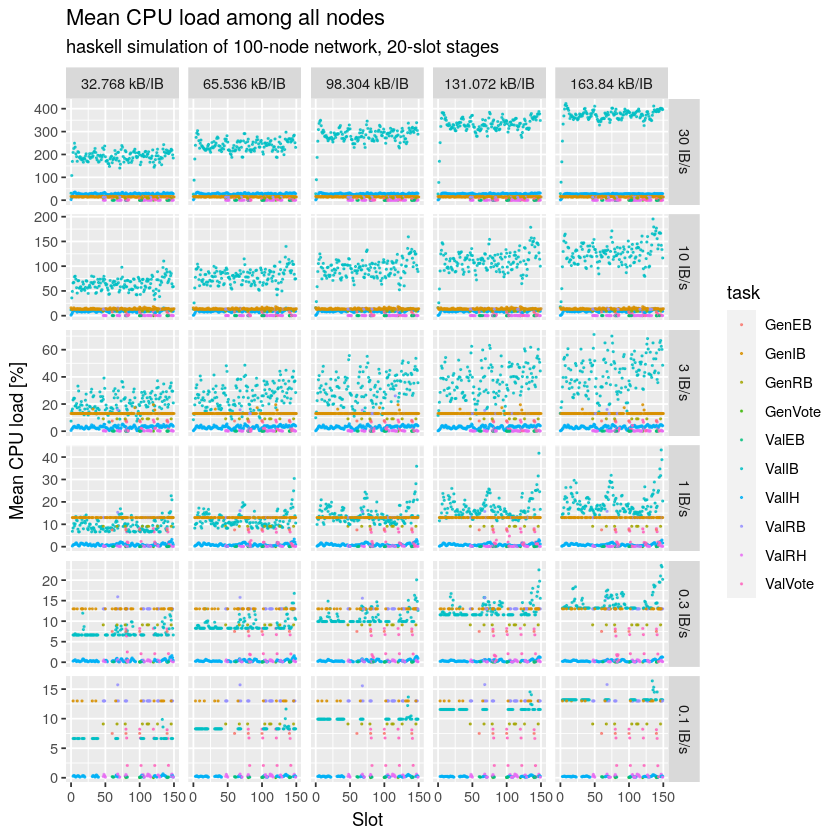

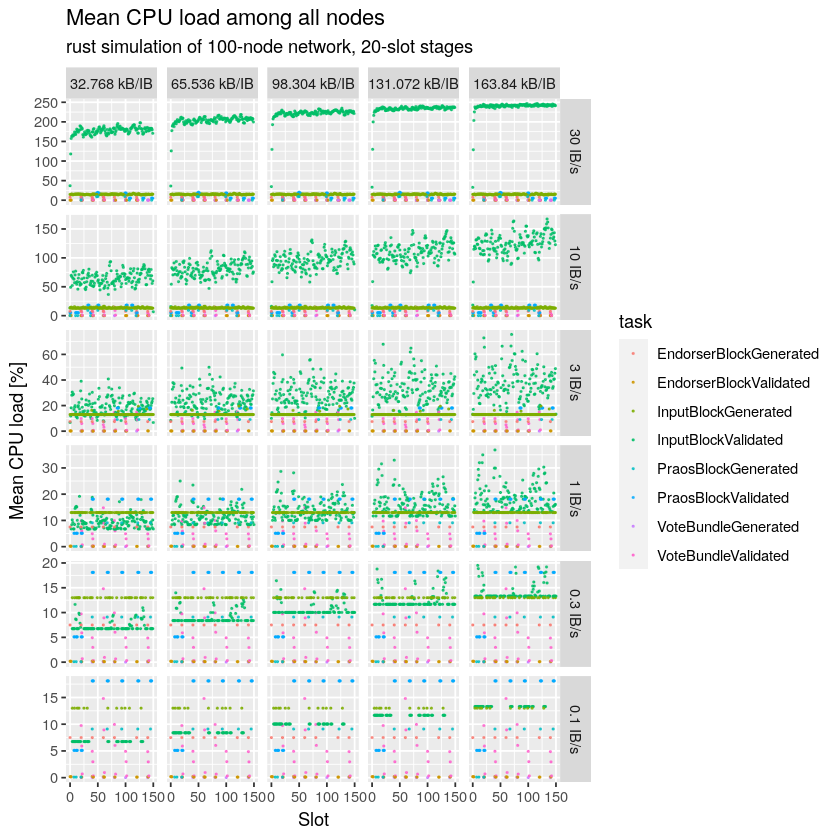

In [20]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

### Fraction throttled

In [21]:
# TBD

### Idle time

In [22]:
# TBD

## Input blocks

### Read results

In [23]:
ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11", collection="ibgen")$find(), stringsAsFactors=TRUE)
ibgen %>% summary

    eb-count         eb-first         eb-last             ib        
 Min.   :0.0000   Min.   : 60.08   Min.   : 60.08   23-0   :    90  
 1st Qu.:0.0000   1st Qu.: 80.08   1st Qu.: 80.08   35-0   :    90  
 Median :0.0000   Median :120.08   Median :120.08   47-0   :    90  
 Mean   :0.4742   Mean   :103.39   Mean   :103.39   52-0   :    90  
 3rd Qu.:0.0000   3rd Qu.:120.08   3rd Qu.:120.08   81-0   :    90  
 Max.   :4.0000   Max.   :140.07   Max.   :140.07   33-0   :    85  
                  NA's   :147284   NA's   :147284   (Other):194600  
 ib-body-avg-size-bytes ib-generation-probability     label       
 Min.   : 32768         Min.   : 0.10             default:195135  
 1st Qu.: 65536         1st Qu.:10.00                             
 Median : 98304         Median :30.00                             
 Mean   : 98303         Mean   :22.83                             
 3rd Qu.:131072         3rd Qu.:30.00                             
 Max.   :163840         Max.   :30.00         

In [24]:
fwrite(ibgen, "results/ibgen.csv")

### IB inculsion in EBs

#### Histogram

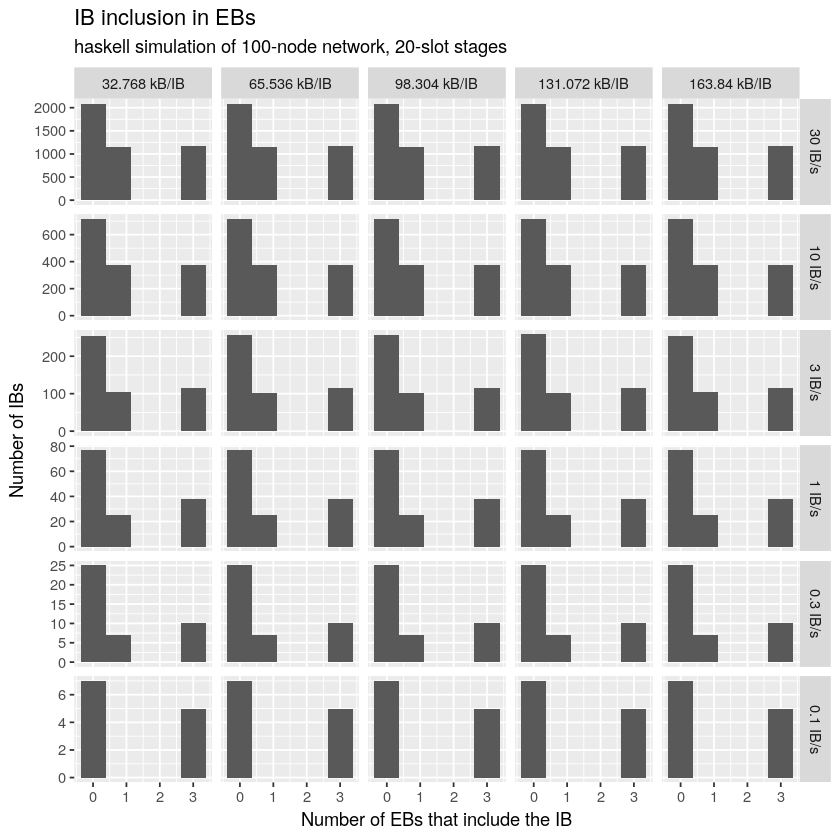

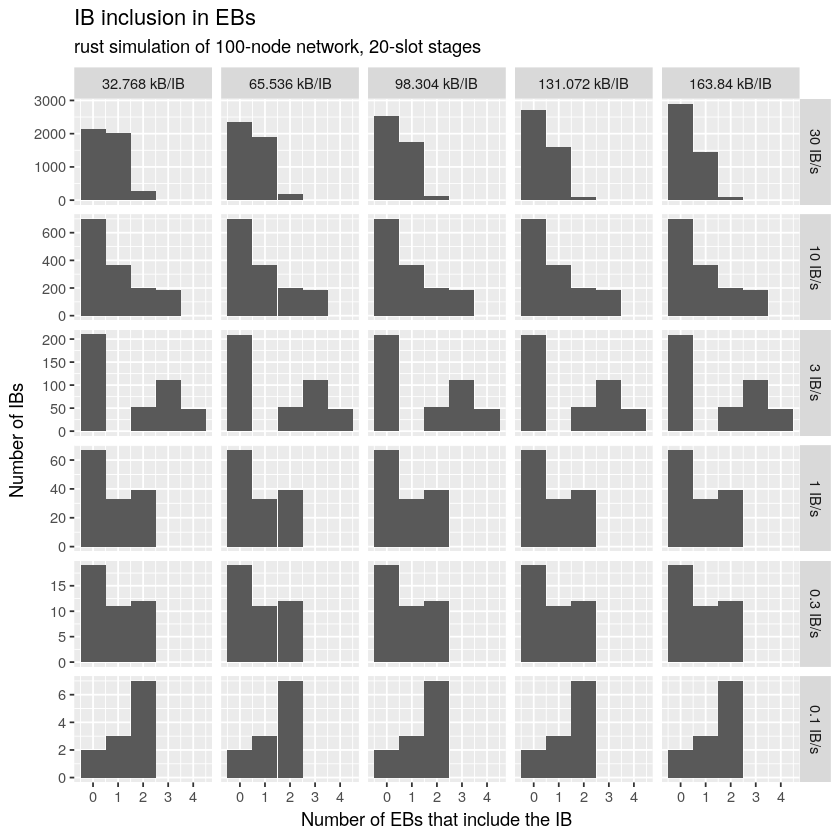

In [25]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

#### Time series

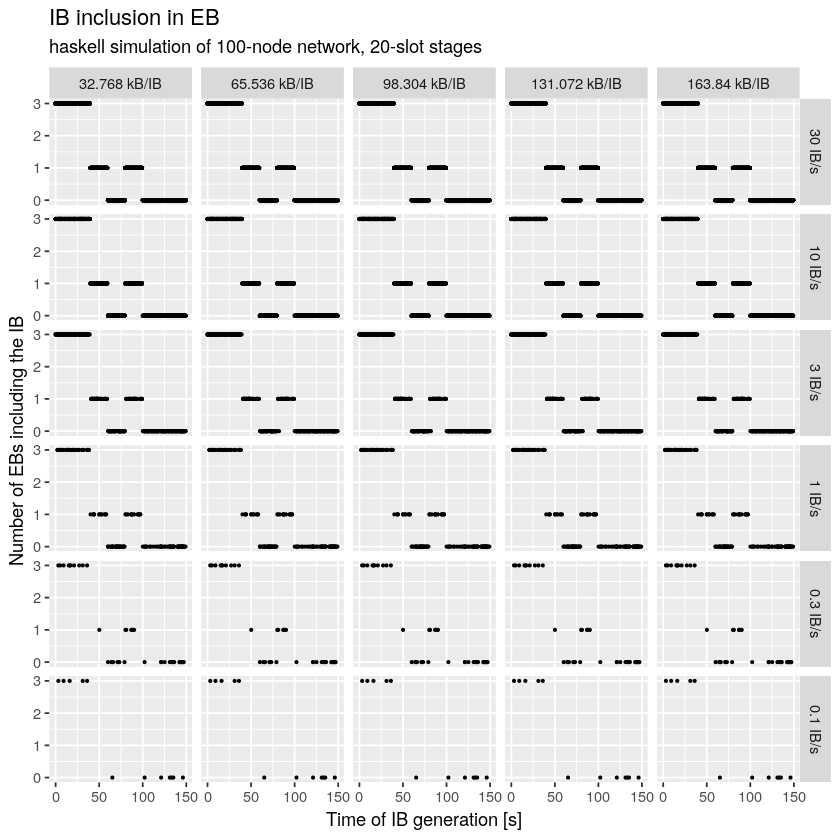

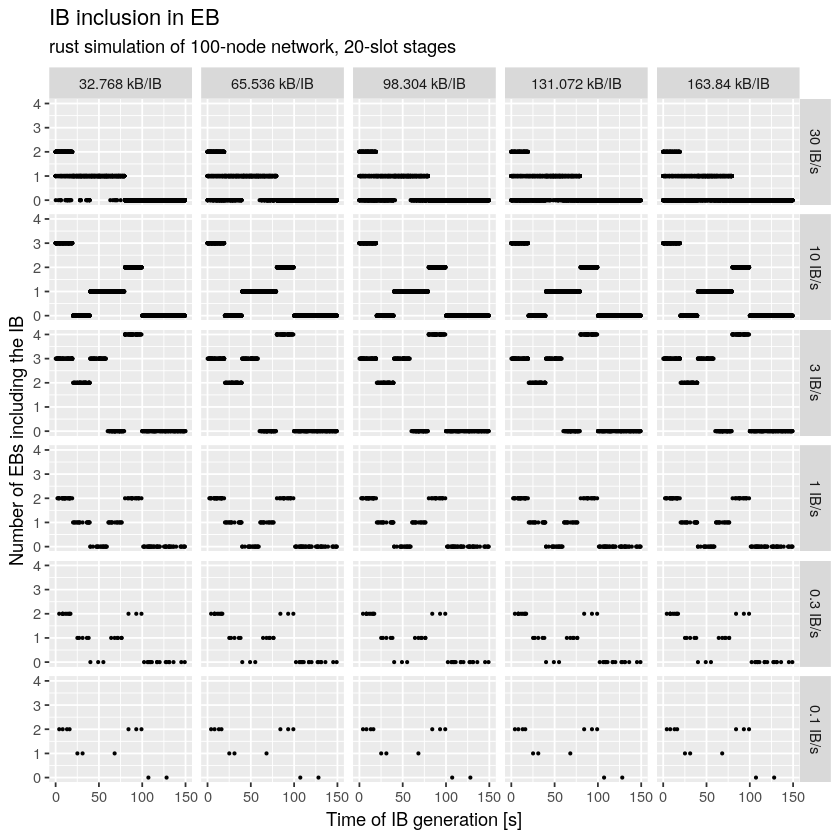

In [26]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

### Time of IB inclusion in an EB

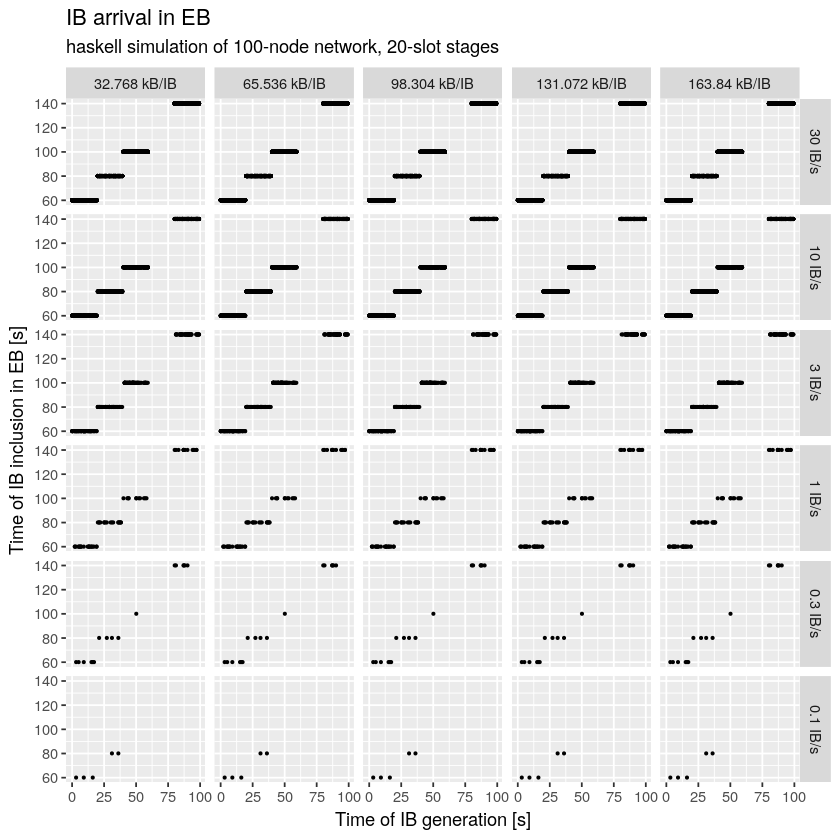

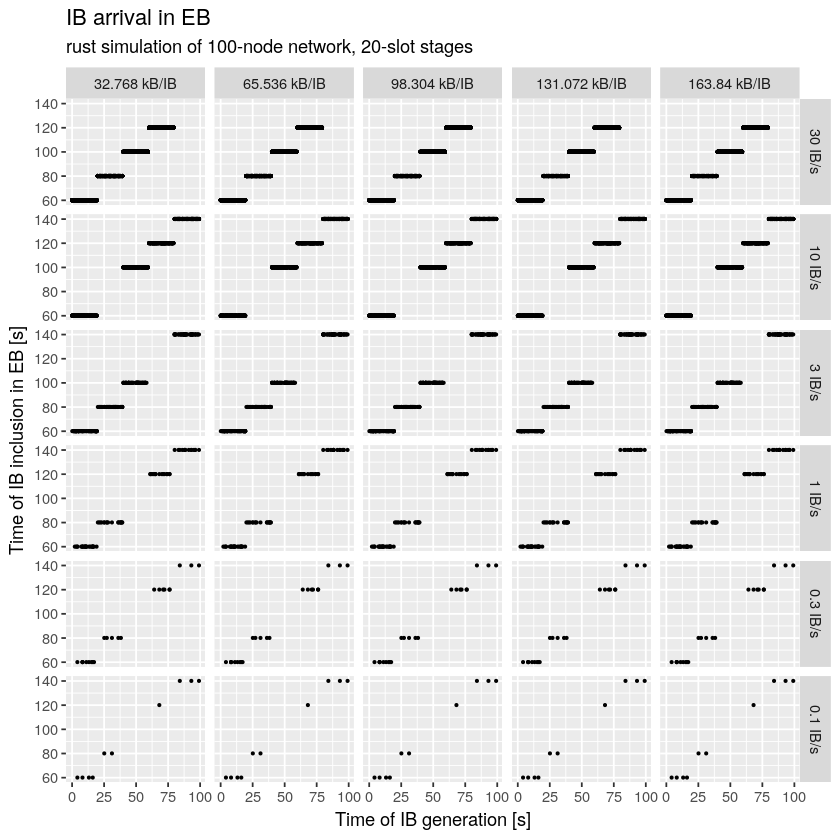

In [27]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 20 & !is.na(`eb-first`),
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

### IB size

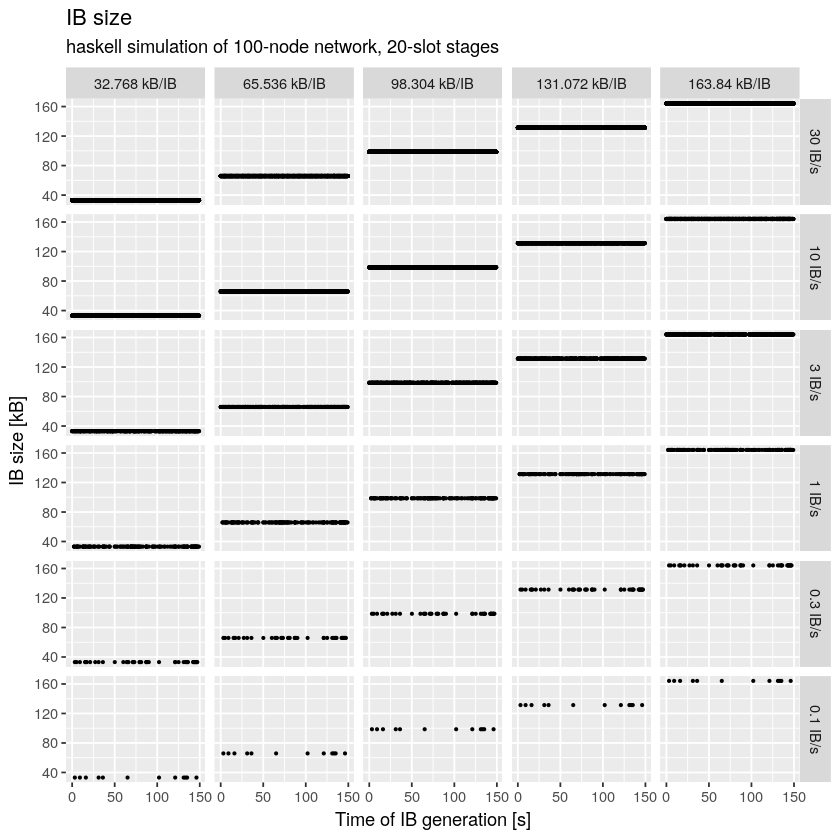

In [28]:
for (s in c("haskell")) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

## Endorser blocks

### Read results

In [29]:
ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11", collection="ebgen")$find(), stringsAsFactors=TRUE)
ebgen %>% summary

           eb      ib-body-avg-size-bytes    ib-count      
 0-node-33  : 90   Min.   : 32768         Min.   :   0.00  
 0-node-91  : 90   1st Qu.: 65536         1st Qu.:   0.00  
 90-0       : 30   Median : 98304         Median :   3.00  
 40-node-82 : 20   Mean   : 98304         Mean   :  86.89  
 120-node-18: 15   3rd Qu.:131072         3rd Qu.:  49.00  
 120-node-45: 15   Max.   :163840         Max.   :1169.00  
 (Other)    :805                                           
 ib-generation-probability     label      leios-stage-length-slots network   
 Min.   : 0.100            default:1065   Min.   :20.00            100:1065  
 1st Qu.: 0.300                           1st Qu.:20.00                      
 Median : 1.000                           Median :20.00                      
 Mean   : 6.988                           Mean   :31.08                      
 3rd Qu.:10.000                           3rd Qu.:40.00                      
 Max.   :30.000                           Max.   :60

In [30]:
fwrite(ebgen, "results/ebgen.csv")

### EB inclusion in RBs

#### Histogram

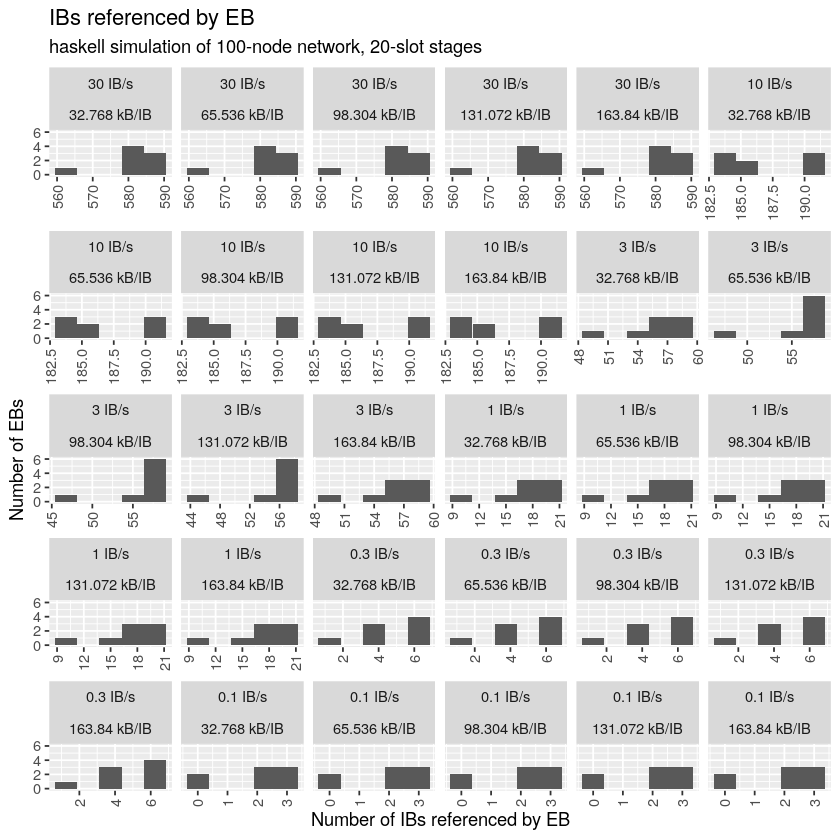

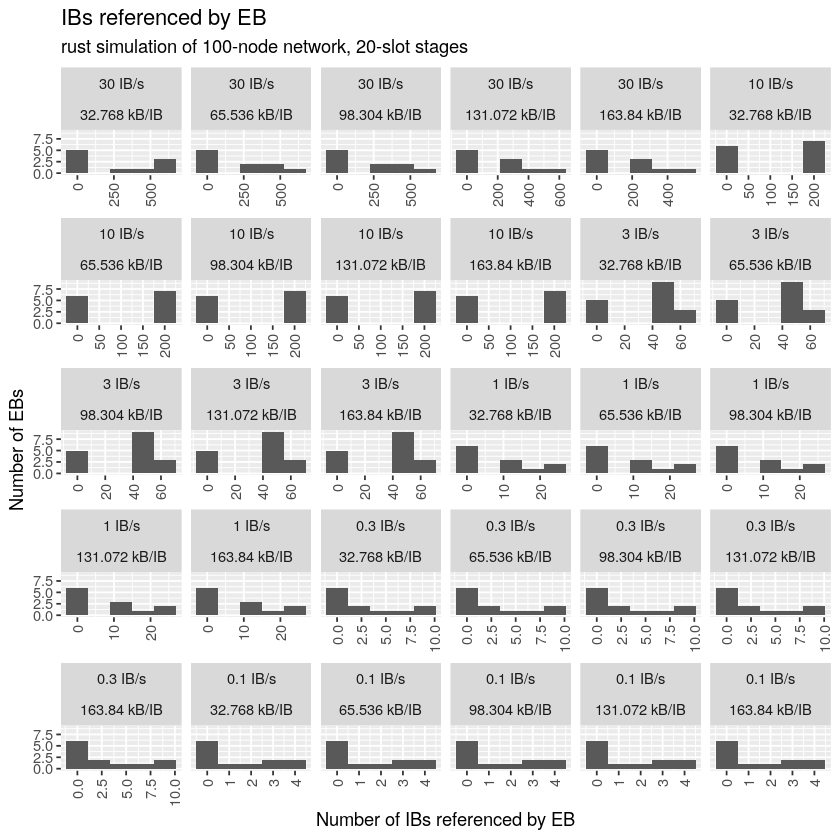

In [31]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle=paste(s, "simulation of 100-node network, 20-slot stages")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(g)

}

#### Time series

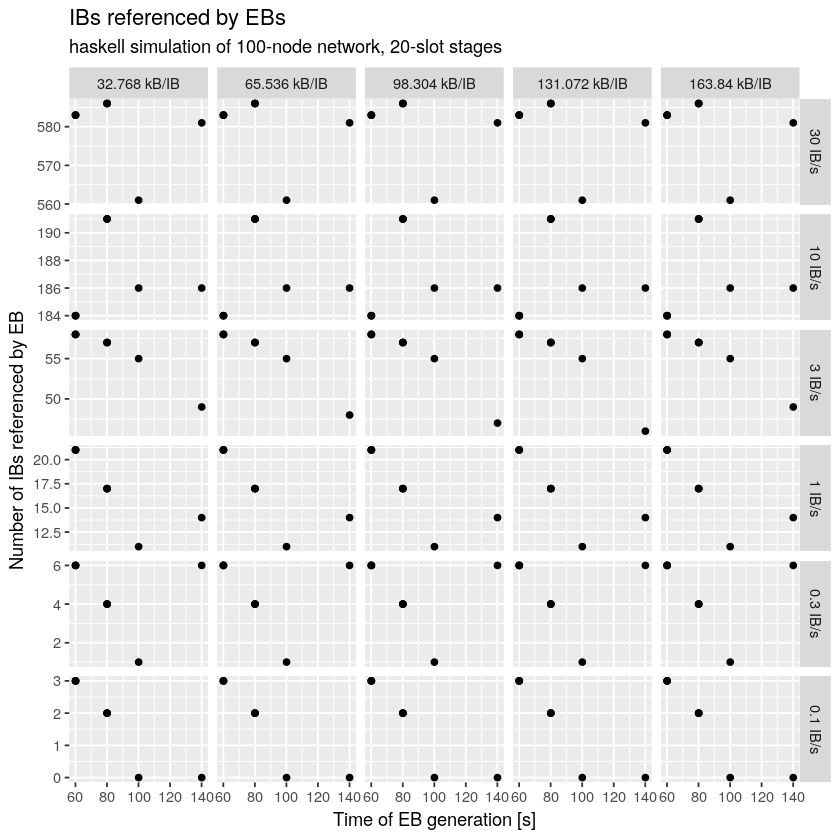

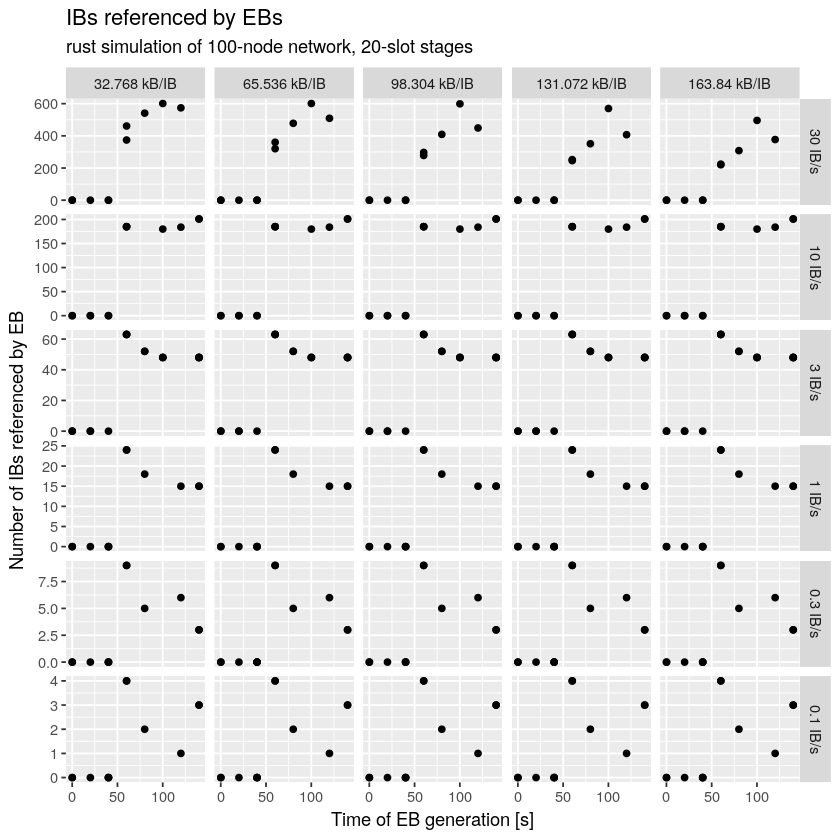

In [32]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

### EB inclusion in RBs

#### Histogram

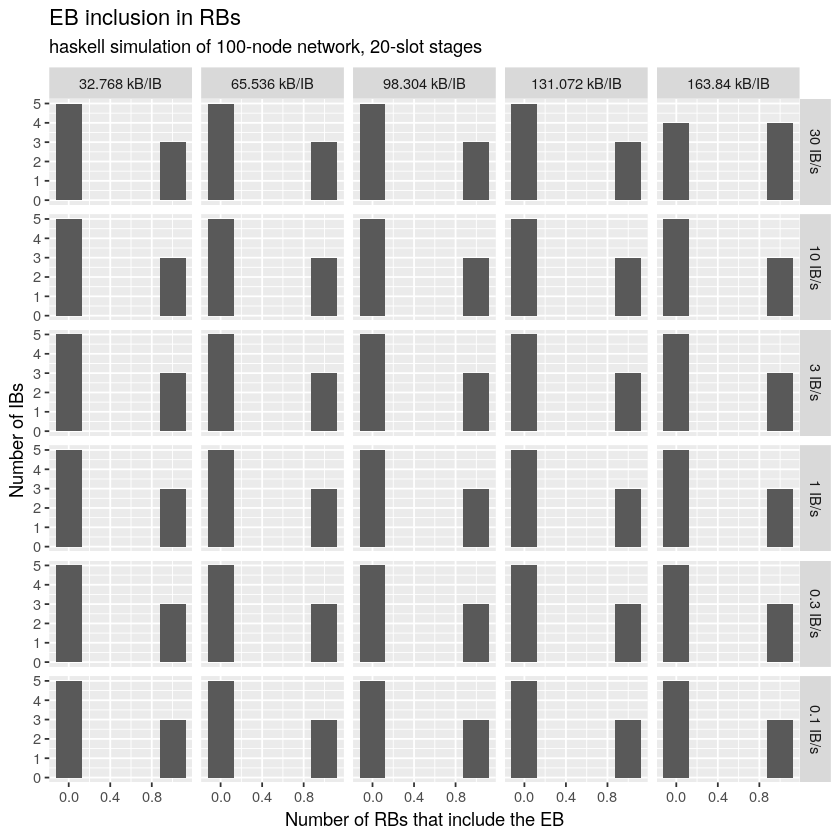

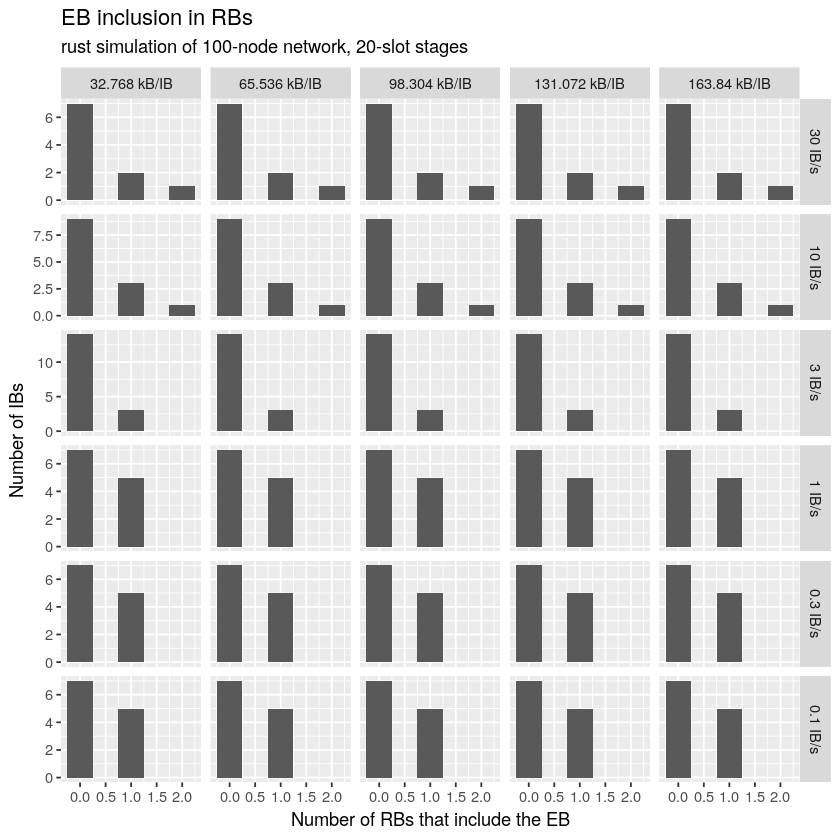

In [33]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("EB inclusion in RBs", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

#### Time series

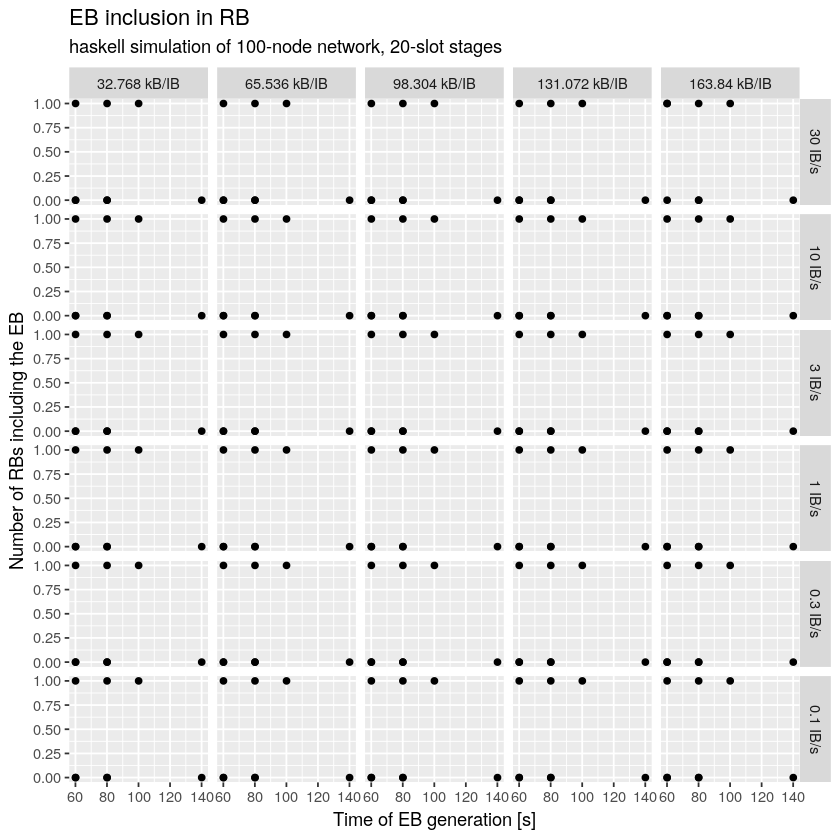

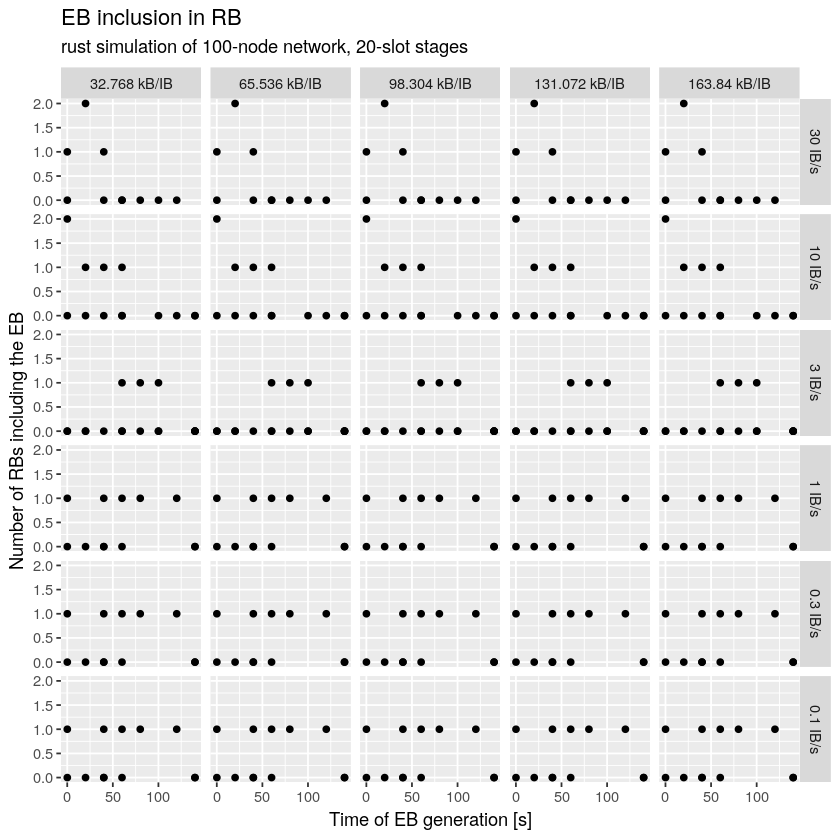

In [34]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

### Time of EB inclusion in an RB

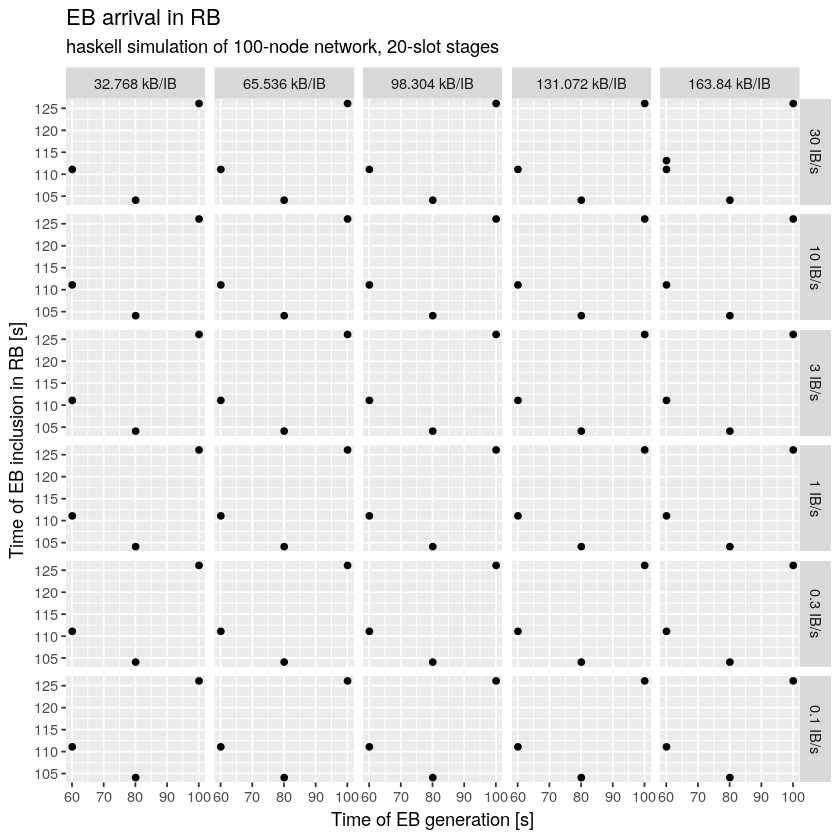

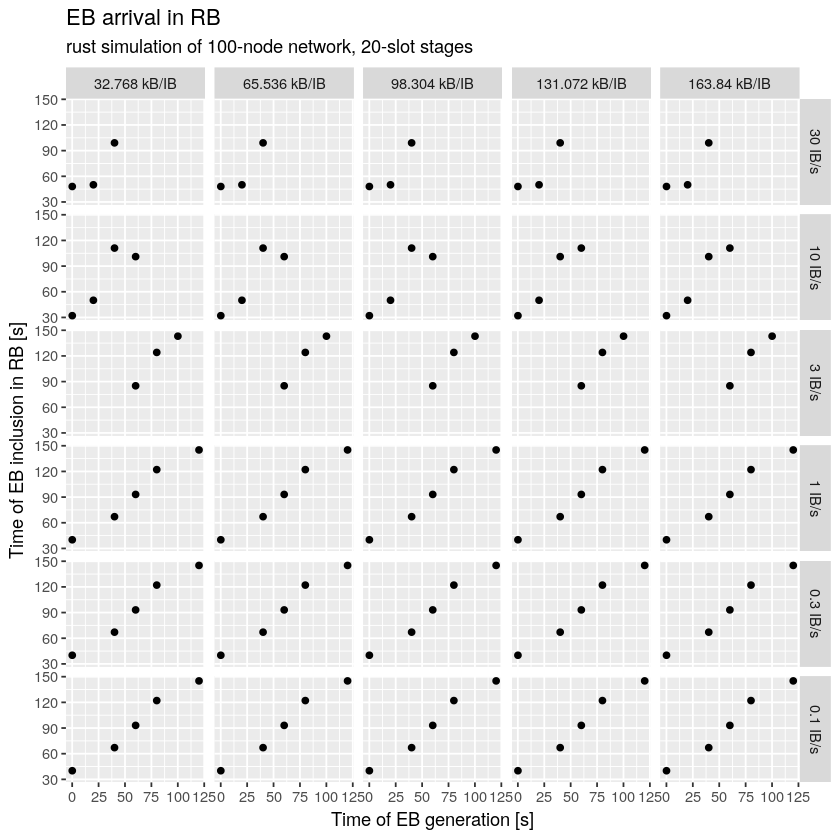

In [35]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20 & `rb-count` > 0,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)

}

### EB size

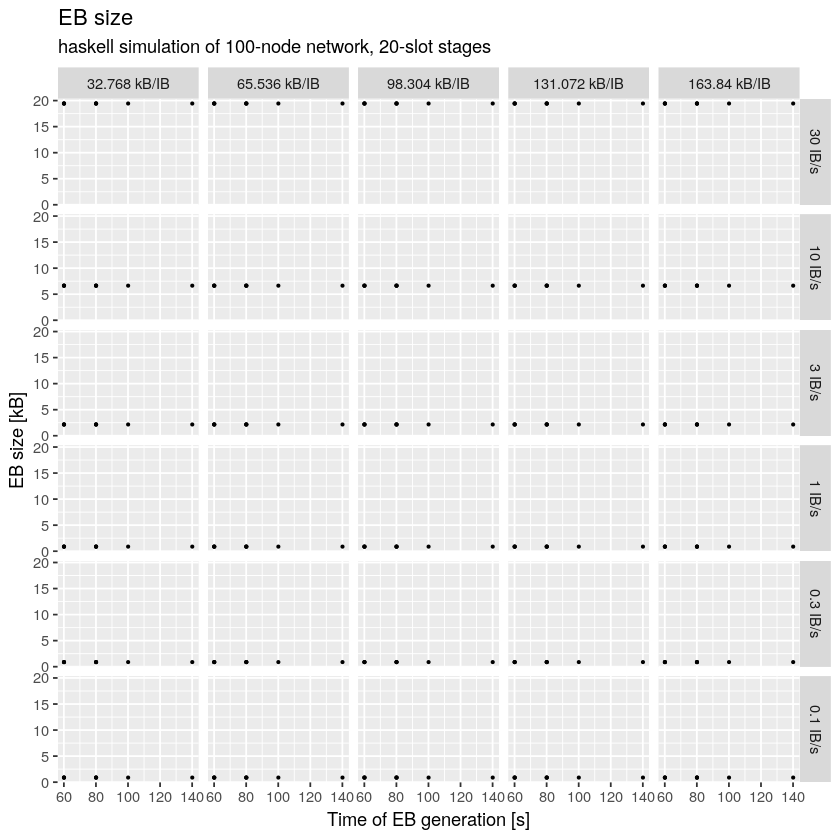

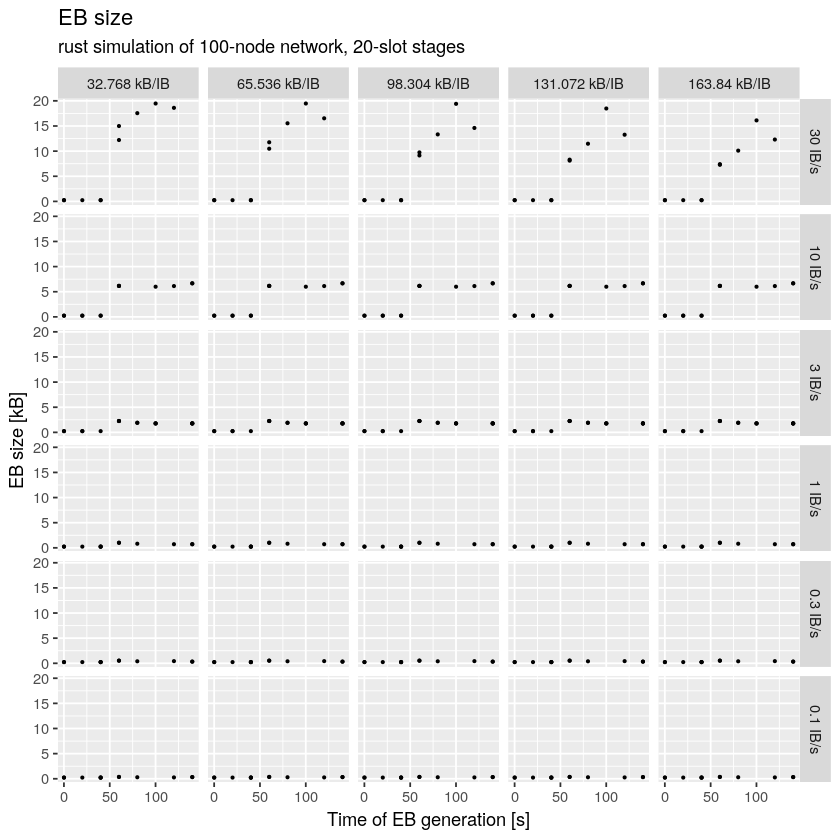

In [36]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

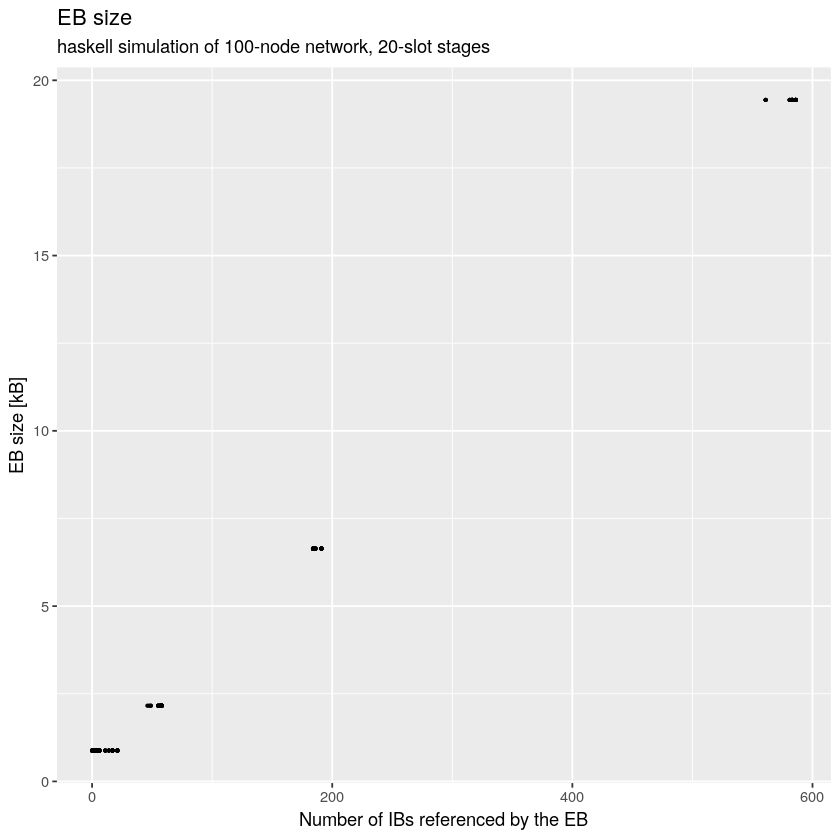

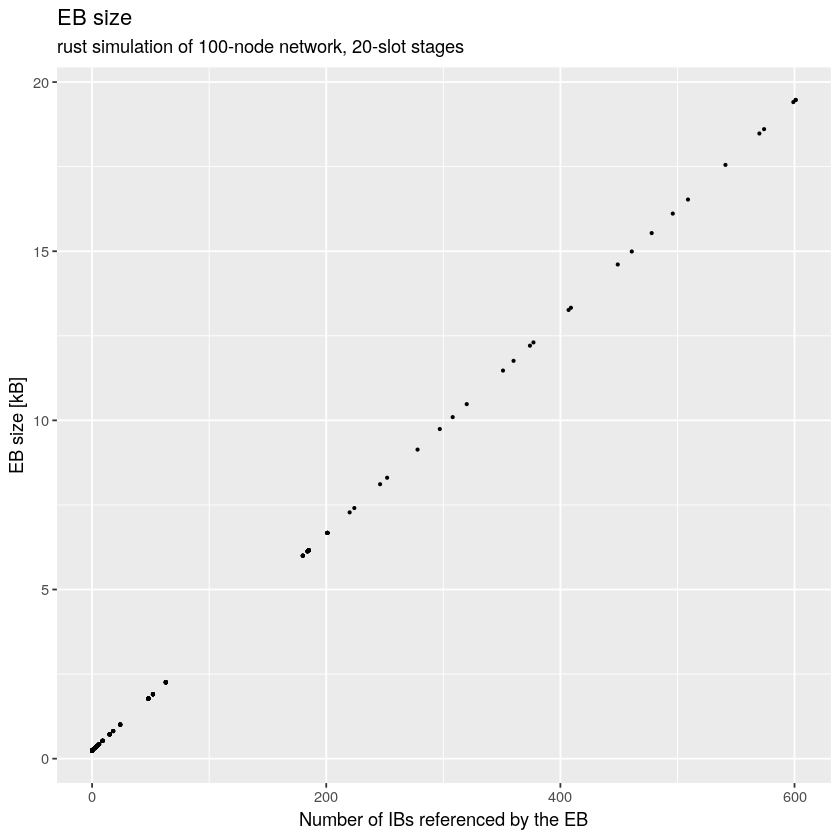

In [37]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by the EB`=`ib-count`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    #facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

## Ranking blocks

### Read results

In [38]:
rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w11", collection="rbgen")$find(), stringsAsFactors=TRUE)
rbgen %>% summary

    eb-count      ib-body-avg-size-bytes ib-generation-probability
 Min.   :0.0000   Min.   : 32768         Min.   : 0.100           
 1st Qu.:0.0000   1st Qu.: 65536         1st Qu.: 0.300           
 Median :0.0000   Median : 98304         Median : 3.000           
 Mean   :0.3387   Mean   : 98304         Mean   : 8.261           
 3rd Qu.:1.0000   3rd Qu.:131072         3rd Qu.:10.000           
 Max.   :1.0000   Max.   :163840         Max.   :30.000           
                                                                  
     label      leios-stage-length-slots network                       rb     
 default:1110   Min.   :20.00            100:1110   -2950746169654411929: 90  
                1st Qu.:20.00                       -8062955889719650687: 60  
                Median :40.00                       -9161735025789408340: 60  
                Mean   :37.21                       1991976363184018089 : 60  
                3rd Qu.:60.00                       -3472384090249572

In [39]:
fwrite(rbgen, "results/rbgen.csv")

### EB inclusion in RBs

#### Histogram

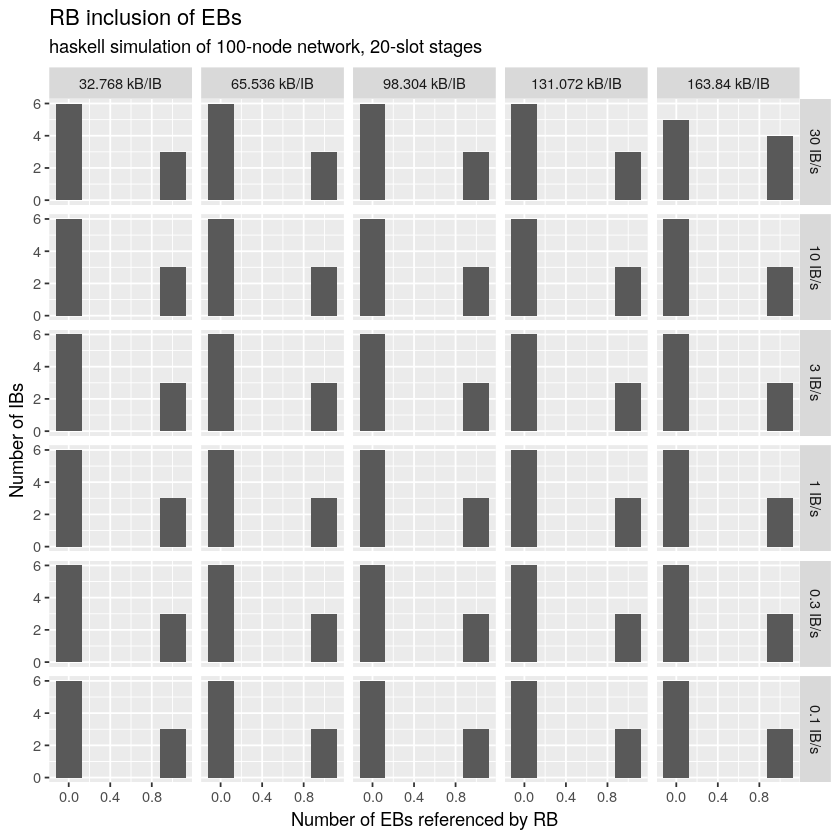

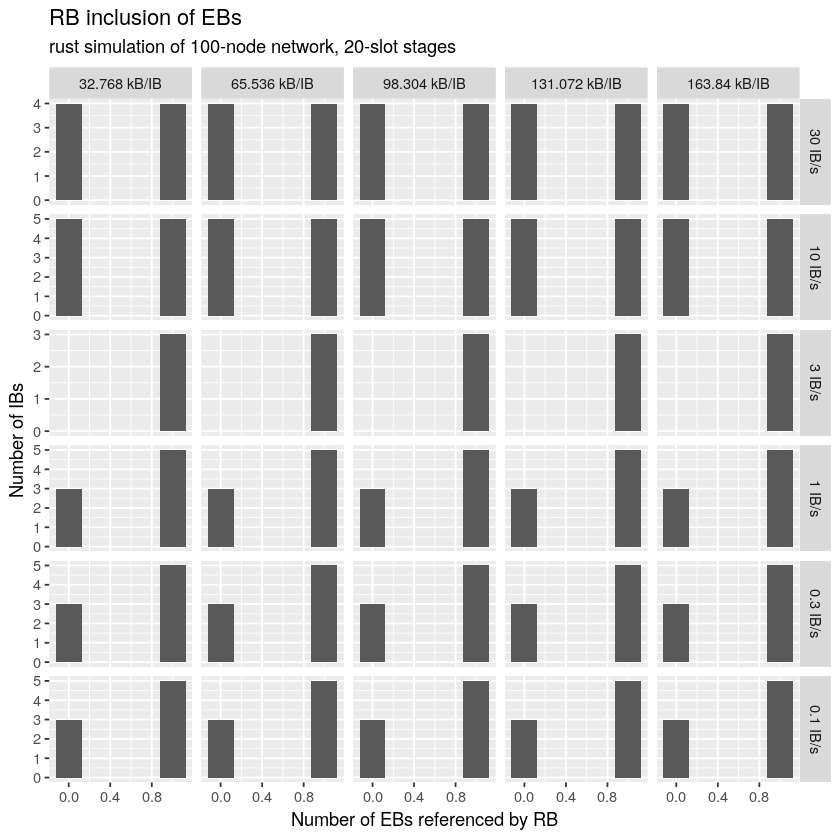

In [40]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ylab("Number of IBs") +
    ggtitle("RB inclusion of EBs", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

#### Time series

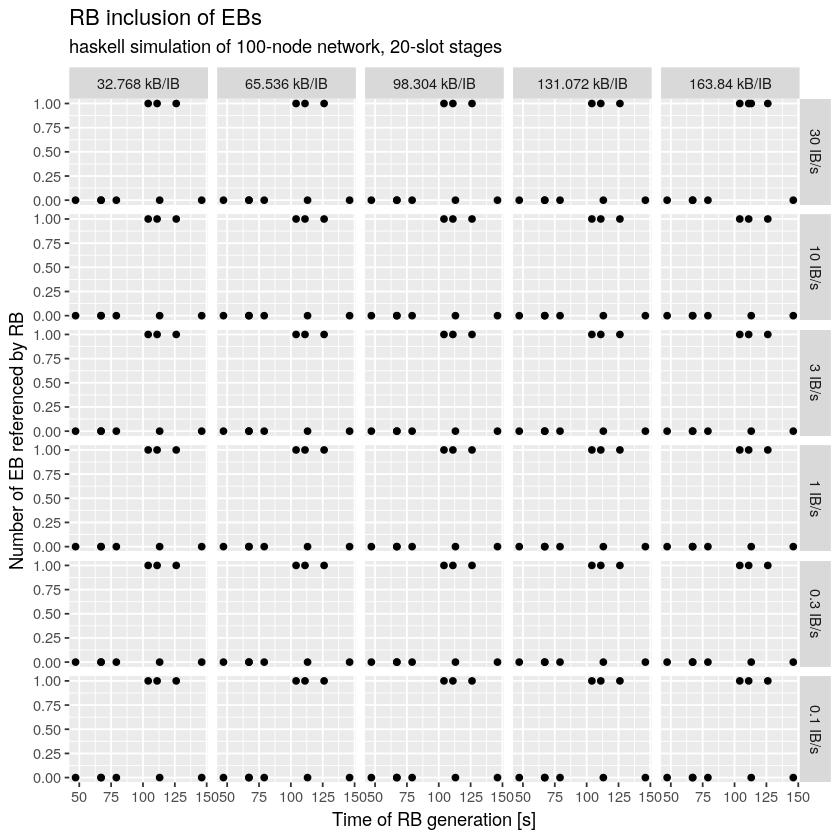

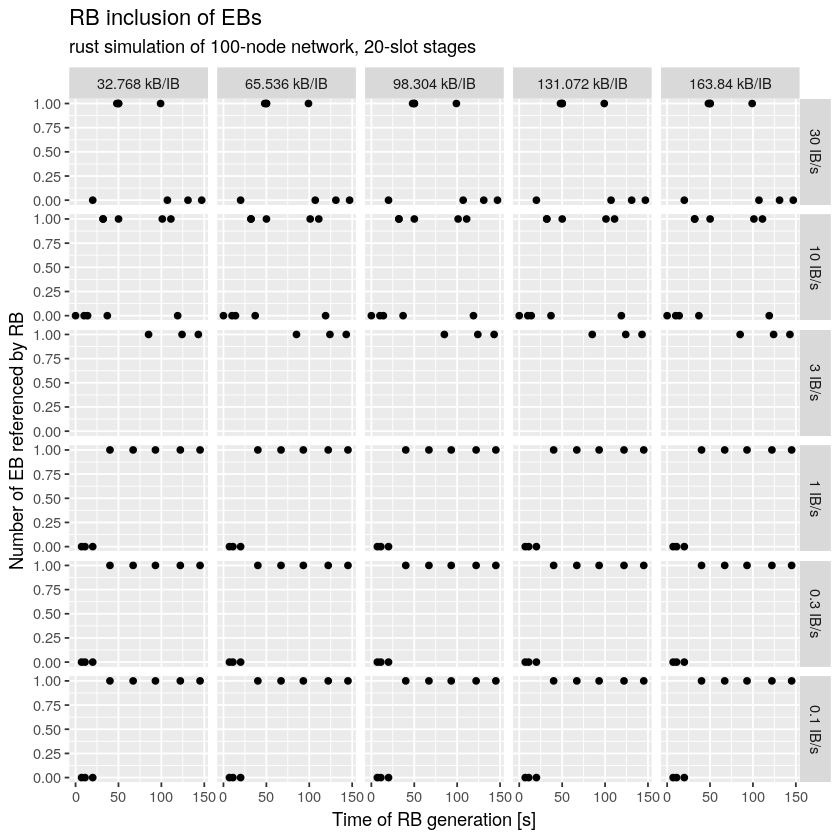

In [41]:
for (s in c("haskell", "rust")) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}

### RB size

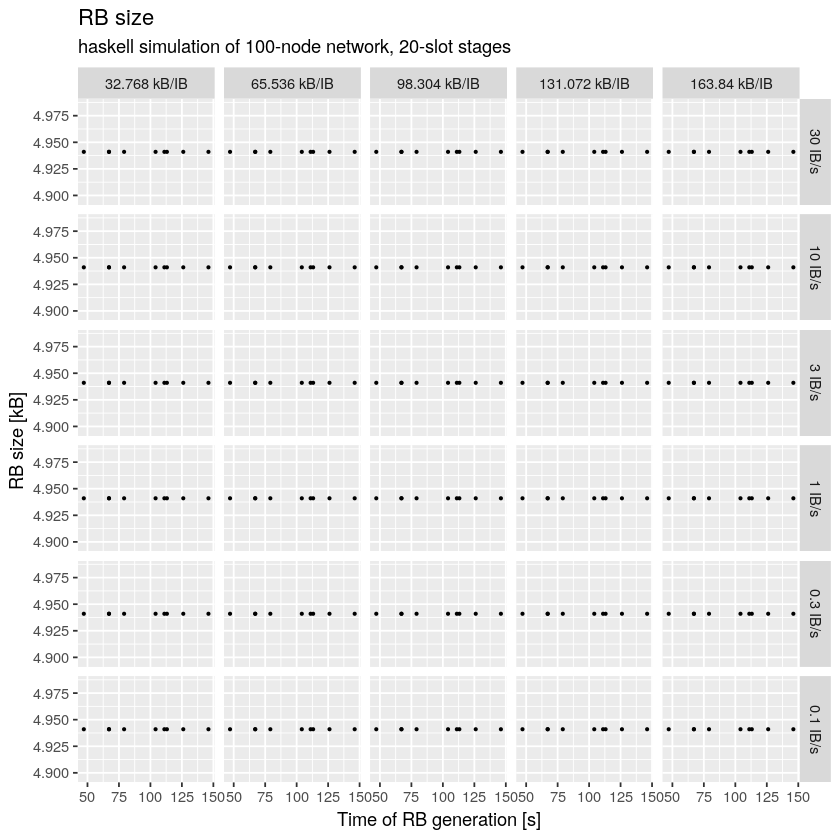

In [42]:
for (s in c("haskell")) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 20,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle=paste(s, "simulation of 100-node network, 20-slot stages"))
print(g)
    
}